# EMNIST DataSet Project

**Mohammad Mazrouei** \
**4003613056** 

# Imports

In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

# Data Preparation 

**Transformations**  
Compose is used to combine multiple transformations into one.  
ToTensor() converts a PIL image or NumPy ndarray to a tensor.  
lambda reshapes the tensor into a 1D tensor with 784 elements (28x28 = 784), which is the flattened version of the MNIST images.  

**Load Dataset**  
The MNIST class is used to download and load the MNIST dataset, applying the transformations to each image in the dataset. 

**Validation Data**  
Validation data is a subset of your dataset that is used to evaluate the performance of a model during training.  
Purpose of Validation Data: Model Evaluation, Hyperparameter Tuning, Early Stopping, Model Selection.

**Show Data**  
show_image(tensor) function reshapes the flattened tensor back to 28x28 and displays it using plt.imshow.  

In [2]:
transform = Compose([
    ToTensor(),
    Lambda(lambda image: image.view(784))
])

data_train = MNIST(root="./", download=True, train=True, transform=transform)
data_test = MNIST(root="./", download=True, train=False, transform=transform)

In [3]:
VALIDATION_SPLIT = 0.1
train_size = int((1 - VALIDATION_SPLIT) * len(data_train))
val_size = len(data_train) - train_size

data_train, data_val = random_split(data_train, [train_size, val_size])

In [4]:
print(f'#NO train data: {len(data_train)}')
print(f'#NO test data:  {len(data_test)}')
print(f'#NO validation data: {len(data_val)}')

#NO train data: 54000
#NO test data:  10000
#NO validation data: 6000


In [5]:
data_train[0][0].shape

torch.Size([784])

/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/mohammad/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecation

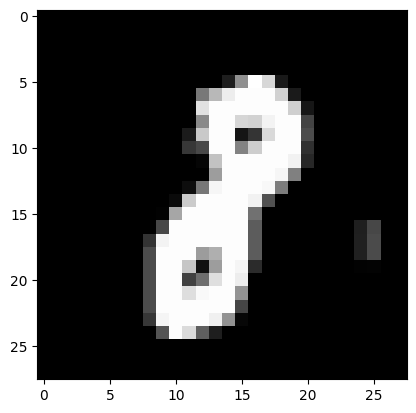

8


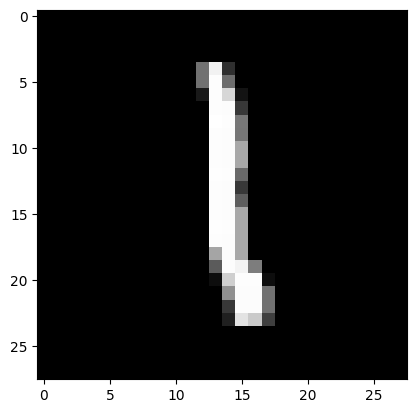

1


In [6]:
def show_image(tensor):
    # Reshape the tensor back to 28x28
    image = tensor.view(28, 28)
    plt.imshow(image, cmap='gray')
    plt.show()

sample_image, label = data_train[0]
show_image(sample_image)
print(label)

sample_image, label = data_train[1]
show_image(sample_image)
print(label)

# Functions

**get_default_device:** This function checks if a GPU (CUDA) is available and returns the corresponding device.  
**to_t:** This function transfers a given tensor to the specified device.

In [11]:
def get_default_device():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def to_t(tensor, device=get_default_device()):
    return tensor.to(device)

**train_the_model:** train model and Returns the list of average training and validation losses for all epochs.  

In [8]:
def train_the_model(mnist_model):
    train_losses = []
    val_losses = []
    
    for epoch in range(EPOCHS):
        mnist_model.train() 
        
        total_train_loss = 0
        for r_xs, r_ys in dataloader_train:
            xs, ys = to_t(r_xs), to_t(r_ys)
            total_train_loss += mnist_model.fit(xs, ys)
        total_train_loss /= len(dataloader_train)
        train_losses.append(total_train_loss)
        
        # Calculate validation loss
        mnist_model.eval()  
        total_val_loss = 0
        with torch.no_grad(): 
            for r_xs, r_ys in dataloader_val:
                xs, ys = to_t(r_xs), to_t(r_ys)
                y_pred = mnist_model.forward(xs)
                total_val_loss += mnist_model.loss(y_pred, ys).item()
        total_val_loss /= len(dataloader_val)
        val_losses.append(total_val_loss)
        
        print(f"EPOCH {epoch + 1}: Train Loss = {total_train_loss:.4f}, Validation Loss = {total_val_loss:.4f}")
    
    return train_losses, val_losses

**plot_loss_curve:** plots the training and validation loss curves over epochs.

In [9]:
def plot_loss_curve(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

**evaluate_model:** evaluates the accuracy of the model on the test dataset by comparing the predicted labels to the true labels and counting the number of correct predictions.

In [10]:
def evaluate_model(model):
    correct = 0
    for r_xs, r_ys in dataloader_test:
        xs, ys = to_t(r_xs), to_t(r_ys)
        y_pred = model.predict(xs)
        correct += (ys == y_pred).sum()
    acc = correct / (len(dataloader_test) * BATCH_SIZE)
    print(f'ACCURACY: {acc:.6f}')
    return acc

**create_bar_chart:** creates a bar chart comparing the accuracies of different models, highlighting the model with the highest accuracy in red.

In [12]:
def create_bar_chart(model_names, model_accuracies):
    max_accuracy = max(model_accuracies)
    bars = []
    for i, acc in enumerate(model_accuracies):
        if acc == max_accuracy:
            bars.append(plt.bar(model_names[i], acc, color='red', edgecolor='black', linewidth=1.5))
        else:
            bars.append(plt.bar(model_names[i], acc, color='skyblue', edgecolor='black', linewidth=1.5))
            
    plt.xlabel('Model Name', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Comparison of Model Accuracies', fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Loss & Cross entropy loss

## Loss

Loss, also known as the loss function or cost function, is a measure of how well a machine learning model's predictions match the true labels. It quantifies the difference between the predicted values and the actual values. The goal of training a model is to minimize this loss, thereby improving the accuracy of the model's predictions.

## Cross entropy loss

Cross-Entropy Loss, often used in classification tasks, measures the difference between two probability distributions - the predicted probability distribution and the true distribution (labels). It quantifies how well the predicted probabilities match the actual class labels.

$$ \text{Loss} = -\sum_{i=1}^{C} y_i \log(p_i) $$  
- \( C \) is the number of classes.  
- \( y_i \) is the true label (1 if the instance belongs to class \( i \), 0 otherwise).  
- \( p_i \) is the predicted probability of the instance belonging to class \( i \).  

# Architecture (layer and neurons)

## Explain Model

**init Method**  
*Parameters:*  
input_size=784: Number of input features (default is 784 for flattened 28x28 MNIST images).  
hidden_layers=[512]: List specifying the number of neurons in each hidden layer.  
output_size=10: Number of output features (default is 10 for the MNIST classification task).  

*Sequential Layers:*  
self.layers = nn.Sequential(*layers): Combines all the layers into a sequential container.  

*Loss Function:*  
self.loss = nn.CrossEntropyLoss(): Defines the cross-entropy loss function, suitable for classification.  

*Optimizer:*  
self.optimizer = optim.Adam(self.parameters()): Defines the Adam optimizer to update model parameters during training.  

*Device Transfer:*  
self.to(get_default_device()): Moves the model to the appropriate device (CPU or GPU).  

**forward Method**  
Takes input X and passes it through the defined layers.  
Returns the output of the final layer.  

**predict Method**  
Disables gradient calculation using torch.no_grad() for prediction to save memory and computation.  
Passes the input X through the model to get the output logits.  
Uses torch.argmax to get the index of the highest logit, which corresponds to the predicted class.  

**fit Method**  
*Zero Gradients:*  
self.optimizer.zero_grad(): Clears the gradients of all optimized tensors.  
*Forward Pass:*  
y_pred = self.forward(X): Computes the forward pass to get the predicted output.  
*Compute Loss:*  
loss = self.loss(y_pred, Y): Calculates the loss between the predicted output y_pred and the true labels Y.  
*Backward Pass:*  
loss.backward(): Backpropagates the error to compute gradients.  
*Optimizer Step:*  
self.optimizer.step(): Updates the model parameters based on the gradients.  
*Return Loss:*  
return loss.item(): Returns the scalar value of the loss for monitoring training progress.  

In [13]:
class Model(nn.Module):
    def __init__(self, input_size=784, hidden_layers=[512], output_size=10):
        super().__init__()
        layers = []
        in_features = input_size
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())
            in_features = hidden_units
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.Sequential(*layers)
        
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred, Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

## How to adjust the number of layers and the number of neurons in each layer?

To calculate the best value for the number of layers and neurons inside each layer,  
we first consider the rest of the parameters constant and run the model for different layer and neurons values.  

**Effect of Number of Layers and Neurons**  
*Underfitting:*  
Model1 and Model2: These models underfit due to insufficient neurons. They are too simple to capture the complexities of the data.  
Indicators: High training loss values and slow improvement across epochs.  

*Balanced Fit:*  
Model3 and Model4: These models balance capacity and performance well. They have enough neurons to learn the data without being too complex.  
Indicators: Rapid decrease in loss values and lower final loss.  

*Overfitting:*  
Model5, Model6, Model7, Model8: These models show signs of overfitting within 5 epochs.  
Indicators: constant or increase validation loss values in epochs.  

**Best Model**  
Model4 (hidden_layers = [512]) the best model considering the following factors:  
Performance: It achieves low loss values early in training, comparable to larger models.  
Simplicity: It maintains simplicity with a single hidden layer, reducing the risk of overfitting and computational cost.  

In [14]:
model_names = []
model_accuracies = []

**BATCH_SIZE:** The number of samples processed before the model is updated.  
**EPOCHS:** The number of complete passes through the training dataset.  
**dataloader_train:** Loads the training dataset in batches of size BATCH_SIZE and shuffles the data.  
**dataloader_test:** Loads the test dataset in batches of size BATCH_SIZE and shuffles the data.  
**dataloader_val:** Loads the validation dataset in batches of size BATCH_SIZE and shuffles the data.  

In [15]:
BATCH_SIZE = 16
EPOCHS = 5
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

EPOCH 1: Train Loss = 1.5563, Validation Loss = 1.2064
EPOCH 2: Train Loss = 1.1779, Validation Loss = 1.0896
EPOCH 3: Train Loss = 1.0976, Validation Loss = 1.0398
EPOCH 4: Train Loss = 1.0543, Validation Loss = 1.0052
EPOCH 5: Train Loss = 1.0289, Validation Loss = 0.9907
ACCURACY: 0.664300


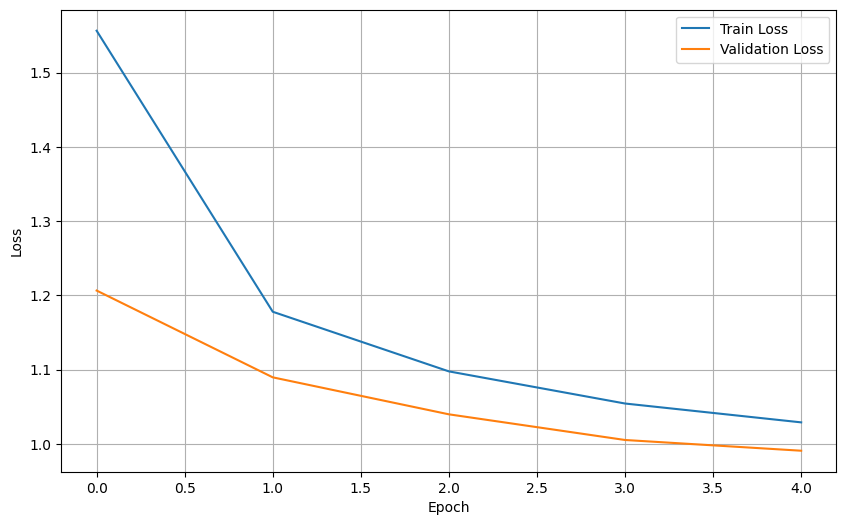

In [16]:
model1 = Model(hidden_layers = [2])
training_loss_model1, val_loss_model1 = train_the_model(model1)
acc_model1 = evaluate_model(model1)

model_names.append('model1')
model_accuracies.append(acc_model1)
plot_loss_curve(training_loss_model1, val_loss_model1)

EPOCH 1: Train Loss = 0.5478, Validation Loss = 0.3437
EPOCH 2: Train Loss = 0.3351, Validation Loss = 0.3009
EPOCH 3: Train Loss = 0.3023, Validation Loss = 0.2933
EPOCH 4: Train Loss = 0.2832, Validation Loss = 0.2822
EPOCH 5: Train Loss = 0.2702, Validation Loss = 0.2641
ACCURACY: 0.922200


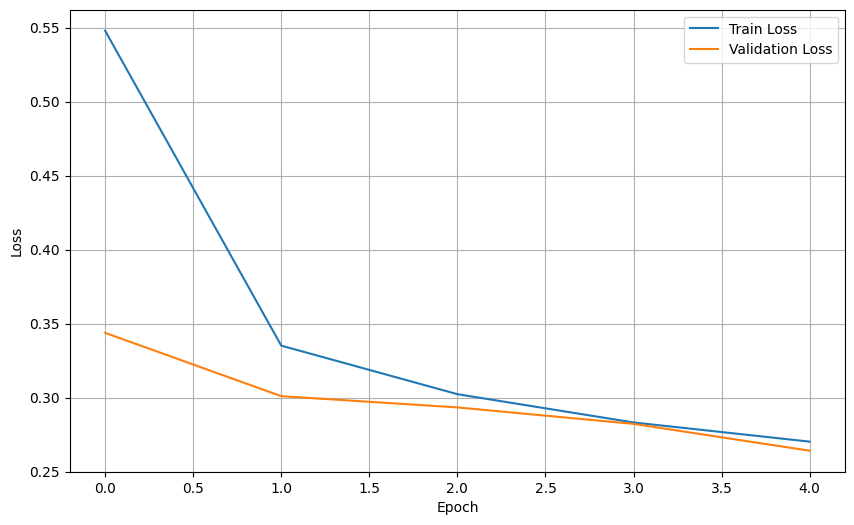

In [17]:
model2 = Model(hidden_layers = [8])
training_loss_model2, val_loss_model2 = train_the_model(model2)
acc_model2 = evaluate_model(model2)

model_names.append('model2')
model_accuracies.append(acc_model2)
plot_loss_curve(training_loss_model2, val_loss_model2)

EPOCH 1: Train Loss = 0.2332, Validation Loss = 0.1218
EPOCH 2: Train Loss = 0.0959, Validation Loss = 0.0935
EPOCH 3: Train Loss = 0.0635, Validation Loss = 0.0969
EPOCH 4: Train Loss = 0.0456, Validation Loss = 0.0696
EPOCH 5: Train Loss = 0.0342, Validation Loss = 0.0915
ACCURACY: 0.975200


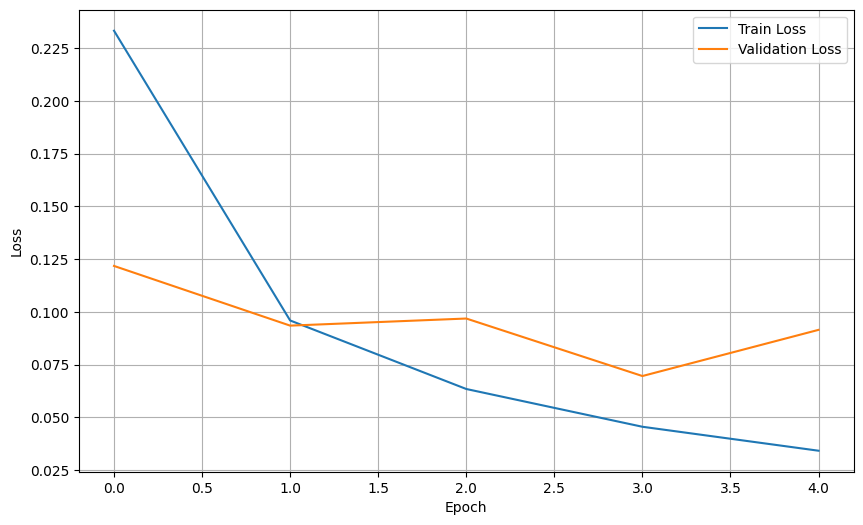

In [18]:
model3 = Model(hidden_layers = [256])
training_loss_model3, val_loss_model3 = train_the_model(model3)
acc_model3 = evaluate_model(model3)

model_names.append('model3')
model_accuracies.append(acc_model3)
plot_loss_curve(training_loss_model3, val_loss_model3)

EPOCH 1: Train Loss = 0.2111, Validation Loss = 0.1009
EPOCH 2: Train Loss = 0.0830, Validation Loss = 0.0893
EPOCH 3: Train Loss = 0.0545, Validation Loss = 0.0873
EPOCH 4: Train Loss = 0.0383, Validation Loss = 0.0705
EPOCH 5: Train Loss = 0.0308, Validation Loss = 0.0954
ACCURACY: 0.975900


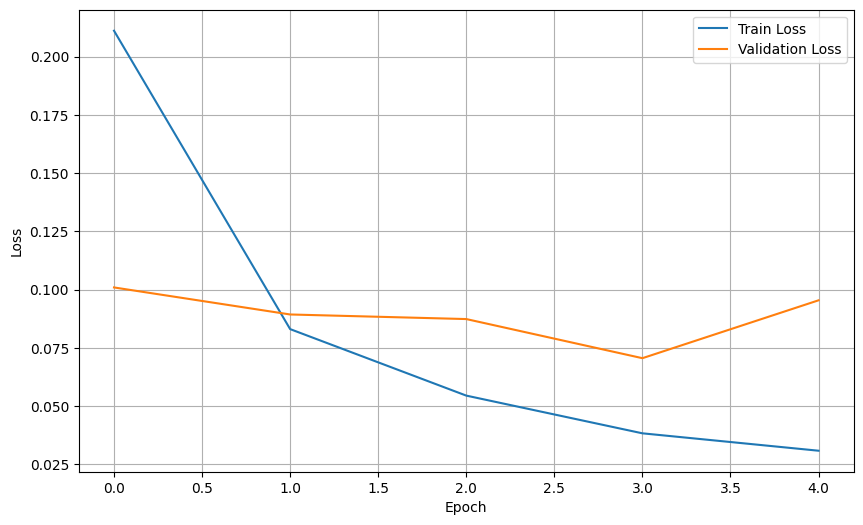

In [19]:
model4 = Model(hidden_layers = [512])
training_loss_model4, val_loss_model4 = train_the_model(model4)
acc_model4 = evaluate_model(model4)

model_names.append('model4')
model_accuracies.append(acc_model4)
plot_loss_curve(training_loss_model4, val_loss_model4)

EPOCH 1: Train Loss = 0.1941, Validation Loss = 0.0990
EPOCH 2: Train Loss = 0.0792, Validation Loss = 0.0840
EPOCH 3: Train Loss = 0.0527, Validation Loss = 0.0825
EPOCH 4: Train Loss = 0.0389, Validation Loss = 0.0881
EPOCH 5: Train Loss = 0.0306, Validation Loss = 0.0884
ACCURACY: 0.977600


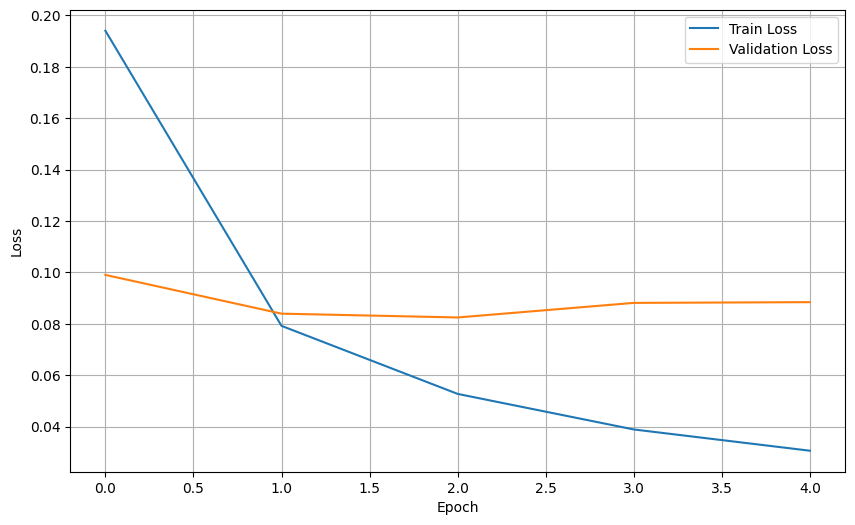

In [20]:
model5 = Model(hidden_layers = [1024])
training_loss_model5, val_loss_model5 = train_the_model(model5)
acc_model5 = evaluate_model(model5)

model_names.append('model5')
model_accuracies.append(acc_model5)
plot_loss_curve(training_loss_model5, val_loss_model5)

EPOCH 1: Train Loss = 0.2038, Validation Loss = 0.1052
EPOCH 2: Train Loss = 0.0889, Validation Loss = 0.0883
EPOCH 3: Train Loss = 0.0658, Validation Loss = 0.0956
EPOCH 4: Train Loss = 0.0515, Validation Loss = 0.0873
EPOCH 5: Train Loss = 0.0406, Validation Loss = 0.0933
ACCURACY: 0.976700


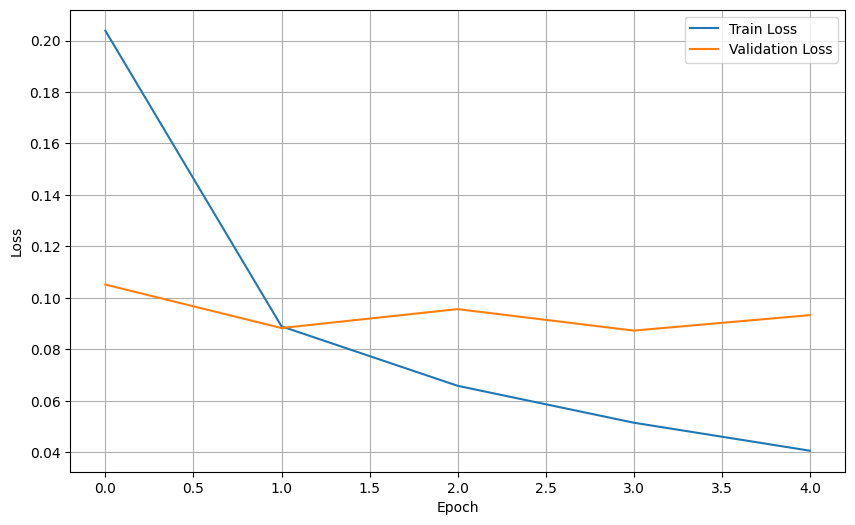

In [21]:
model6 = Model(hidden_layers = [512, 512])
training_loss_model6, val_loss_model6 = train_the_model(model6)
acc_model6 = evaluate_model(model6)

model_names.append('model6')
model_accuracies.append(acc_model6)
plot_loss_curve(training_loss_model6, val_loss_model6)

EPOCH 1: Train Loss = 0.2291, Validation Loss = 0.1461
EPOCH 2: Train Loss = 0.1060, Validation Loss = 0.1078
EPOCH 3: Train Loss = 0.0753, Validation Loss = 0.0960
EPOCH 4: Train Loss = 0.0606, Validation Loss = 0.0918
EPOCH 5: Train Loss = 0.0487, Validation Loss = 0.0972
ACCURACY: 0.978900


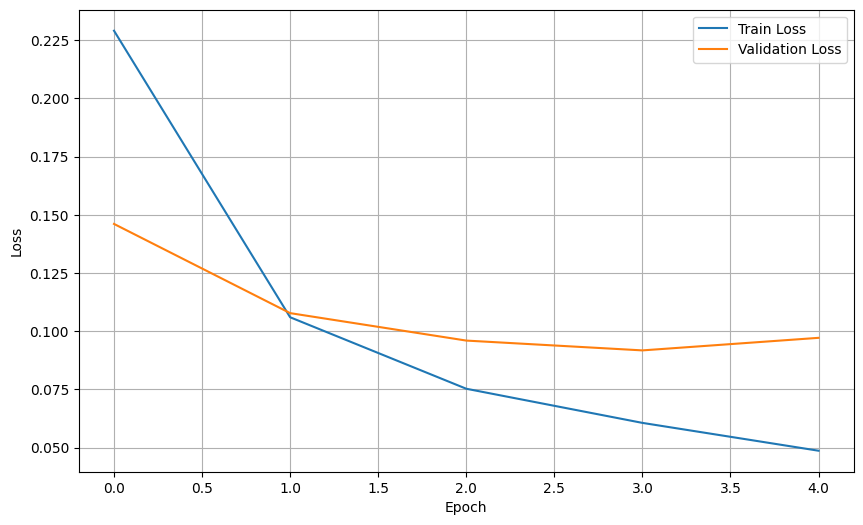

In [22]:
model7 = Model(hidden_layers = [512, 256, 512])
training_loss_model7, val_loss_model7 = train_the_model(model7)
acc_model7 = evaluate_model(model7)

model_names.append('model7')
model_accuracies.append(acc_model7)
plot_loss_curve(training_loss_model7, val_loss_model7)

EPOCH 1: Train Loss = 0.2556, Validation Loss = 0.1342
EPOCH 2: Train Loss = 0.1195, Validation Loss = 0.1278
EPOCH 3: Train Loss = 0.0850, Validation Loss = 0.1022
EPOCH 4: Train Loss = 0.0690, Validation Loss = 0.1228
EPOCH 5: Train Loss = 0.0576, Validation Loss = 0.1065
ACCURACY: 0.968900


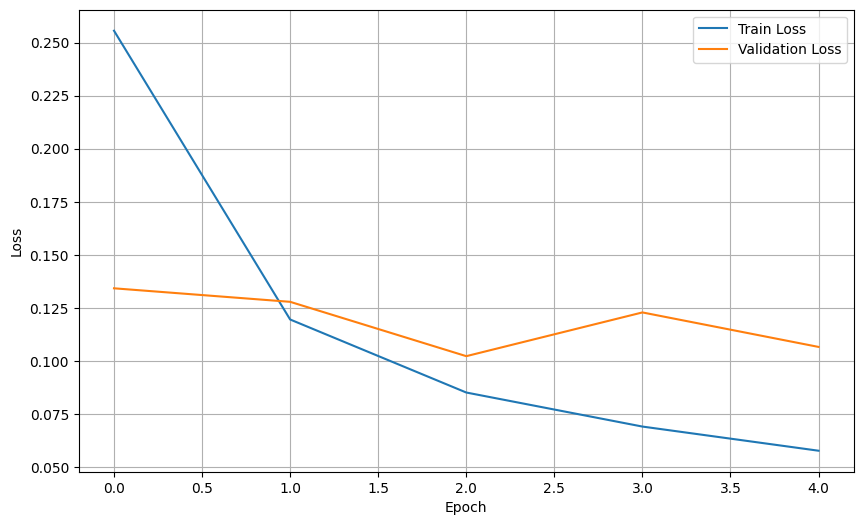

In [23]:
model8 = Model(hidden_layers = [512, 256, 256, 512])
training_loss_model8, val_loss_model8 = train_the_model(model8)
acc_model8 = evaluate_model(model8)

model_names.append('model8')
model_accuracies.append(acc_model8)
plot_loss_curve(training_loss_model8, val_loss_model8)

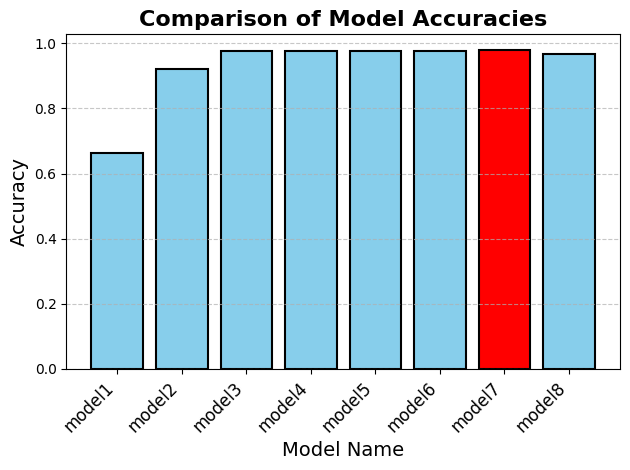

In [24]:
create_bar_chart(model_names, model_accuracies)

# Optimizers

## Optimizer

An optimizer is an algorithm or method used to adjust the parameters (weights and biases) of the model to minimize the loss function. The optimizer plays a crucial role in training the model efficiently and effectively.

### How Optimizers Work

1. **Initialize Parameters**: Start with initial values for the model parameters (often randomly).
2. **Compute Gradients**: During each iteration, compute the gradient of the loss function with respect to each parameter.
3. **Update Parameters**: Adjust the parameters in the direction that reduces the loss, based on the computed gradients and the optimizer's algorithm.
4. **Repeat**: Continue this process for a specified number of iterations (epochs) or until the loss converges to a minimum value.

### Detailed Steps in an Optimizer

1. **Forward Pass**: Compute the model’s predictions.
2. **Loss Calculation**: Calculate the loss by comparing predictions to the actual labels.
3. **Backward Pass**: Compute the gradients of the loss with respect to each parameter.
4. **Parameter Update**: Update the parameters using the optimizer's specific update rule.

## Deafualt Value

In [25]:
opt_model_names = []
opt_model_accuracies = []

In [26]:
BATCH_SIZE = 16
EPOCHS = 5
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

## Adam  

Adam (Adaptive Moment Estimation) is a optimization algorithm. It combines the benefits of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).  

**Key Features**  
Adaptive Learning, Moment Estimation

In [27]:
class Model_Adam(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X),axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 0.2111, Validation Loss = 0.1105
EPOCH 2: Train Loss = 0.0847, Validation Loss = 0.0940
EPOCH 3: Train Loss = 0.0559, Validation Loss = 0.0878
EPOCH 4: Train Loss = 0.0399, Validation Loss = 0.0879
EPOCH 5: Train Loss = 0.0315, Validation Loss = 0.0863
ACCURACY: 0.979400


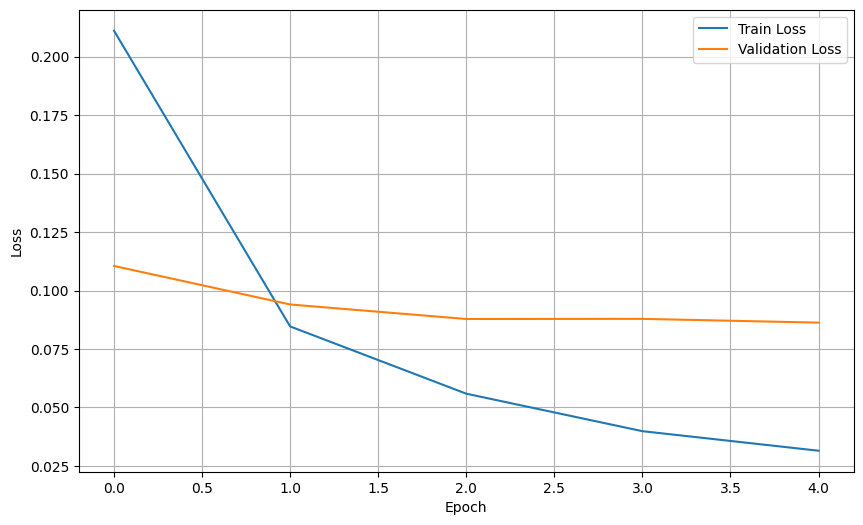

In [28]:
model_Adam = Model_Adam()
training_loss_model_Adam, val_loss_model_Adam = train_the_model(model_Adam)
acc_model_Adam = evaluate_model(model_Adam)

opt_model_names.append('Model_Adam')
opt_model_accuracies.append(acc_model_Adam)
plot_loss_curve(training_loss_model_Adam, val_loss_model_Adam)

## SGD 

Stochastic Gradient Descent (SGD) is an optimization algorithm that updates model parameters iteratively using individual training examples or small batches, allowing for faster and more frequent updates compared to batch gradient descent.

In [29]:
class Model_SGD(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.001)
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X),axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 1.8168, Validation Loss = 1.2513
EPOCH 2: Train Loss = 0.9409, Validation Loss = 0.7111
EPOCH 3: Train Loss = 0.6311, Validation Loss = 0.5416
EPOCH 4: Train Loss = 0.5156, Validation Loss = 0.4636
EPOCH 5: Train Loss = 0.4558, Validation Loss = 0.4196
ACCURACY: 0.893700


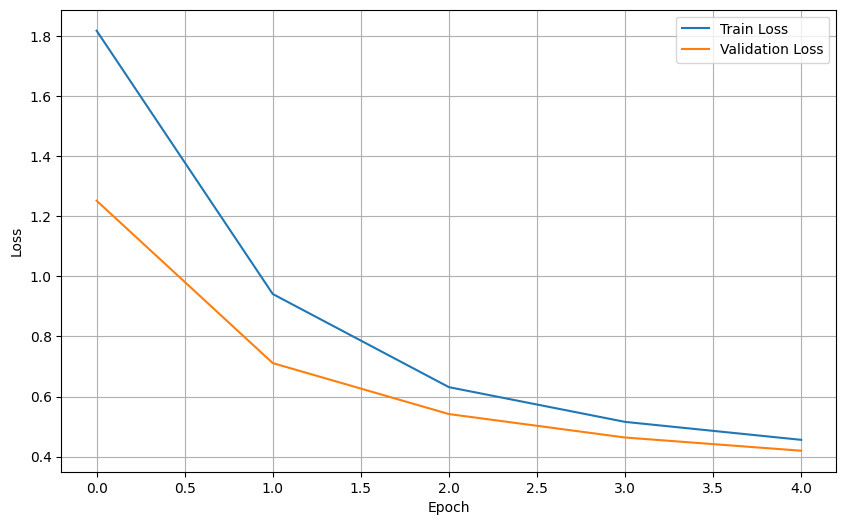

In [30]:
model_SGD = Model_SGD()
training_loss_model_SGD, val_loss_model_SGD = train_the_model(model_SGD)
acc_model_SGD = evaluate_model(model_SGD)

opt_model_names.append('Model_SGD')
opt_model_accuracies.append(acc_model_SGD)
plot_loss_curve(training_loss_model_SGD, val_loss_model_SGD)

## RMSprop  

RMSprop (Root Mean Square Propagation) is an optimization algorithm that adjusts the learning rate for each parameter by dividing the learning rate by an exponentially decaying average of squared gradients, which helps to normalize the updates and improves convergence stability.

In [31]:
class Model_RMSprop(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.RMSprop(self.parameters(), lr=0.001)
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X),axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 0.1918, Validation Loss = 0.1132
EPOCH 2: Train Loss = 0.0818, Validation Loss = 0.0844
EPOCH 3: Train Loss = 0.0546, Validation Loss = 0.1001
EPOCH 4: Train Loss = 0.0407, Validation Loss = 0.0961
EPOCH 5: Train Loss = 0.0304, Validation Loss = 0.0887
ACCURACY: 0.978700


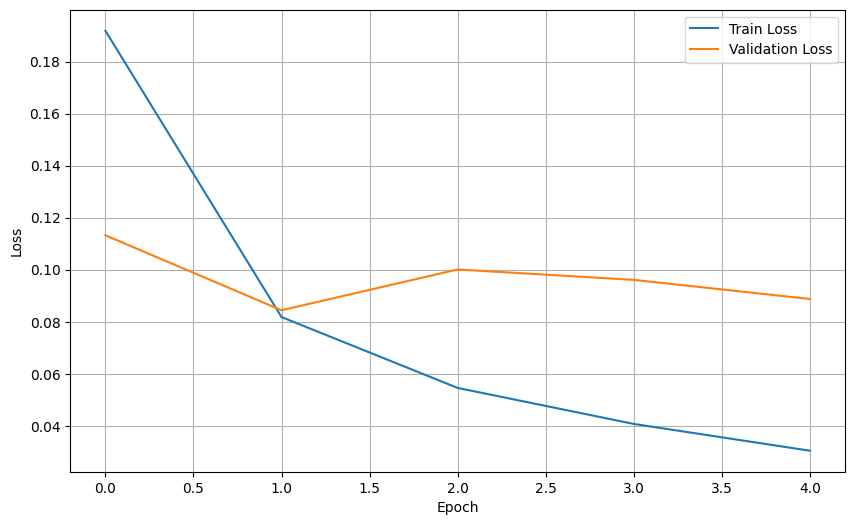

In [32]:
model_RMSprop = Model_RMSprop()
training_loss_model_RMSprop, val_loss_model_RMSprop = train_the_model(model_RMSprop)
acc_model_RMSprop = evaluate_model(model_RMSprop)

opt_model_names.append('Model_RMSprop')
opt_model_accuracies.append(acc_model_RMSprop)
plot_loss_curve(training_loss_model_RMSprop, val_loss_model_RMSprop)

## Adagrad  

Adagrad (Adaptive Gradient Algorithm) is an optimization method that adapts the learning rate for each parameter individually by dividing the learning rate by the square root of the sum of all past squared gradients, which helps to handle sparse data and improve convergence.

In [33]:
class Model_Adagrad(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adagrad(self.parameters(), lr=0.005)
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X),axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 0.2739, Validation Loss = 0.1883
EPOCH 2: Train Loss = 0.1739, Validation Loss = 0.1586
EPOCH 3: Train Loss = 0.1448, Validation Loss = 0.1412
EPOCH 4: Train Loss = 0.1274, Validation Loss = 0.1326
EPOCH 5: Train Loss = 0.1152, Validation Loss = 0.1246
ACCURACY: 0.965600


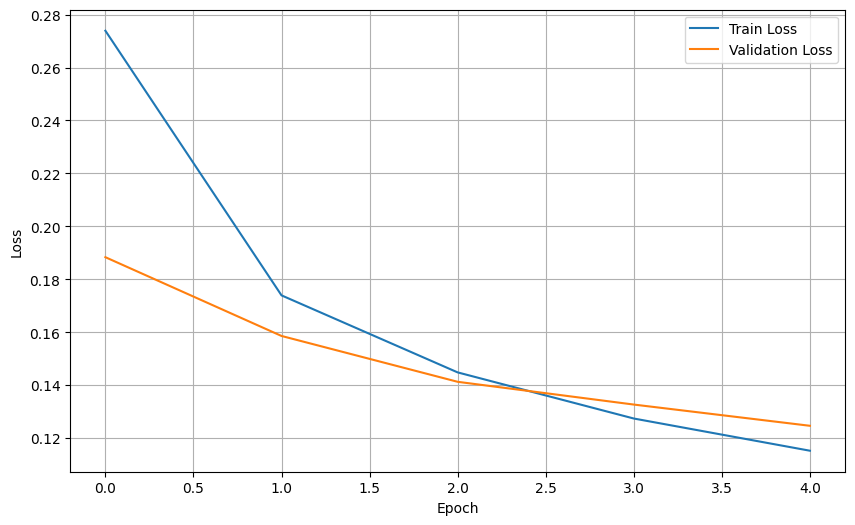

In [34]:
model_Adagrad = Model_Adagrad()
training_loss_model_Adagrad, val_loss_model_Adagrad = train_the_model(model_Adagrad)
acc_model_Adagrad = evaluate_model(model_Adagrad)

opt_model_names.append('Model_Adagrad')
opt_model_accuracies.append(acc_model_Adagrad)
plot_loss_curve(training_loss_model_Adagrad, val_loss_model_Adagrad)

## Accuracies

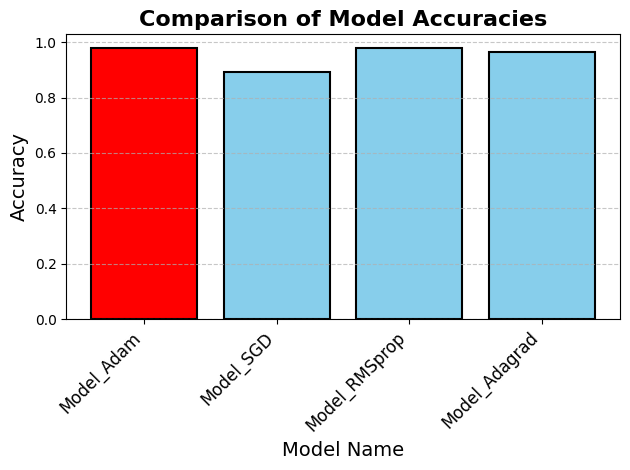

In [35]:
create_bar_chart(opt_model_names, opt_model_accuracies)

## Result

After running the models several times, optimizer Adam and RMSprop have the best accuracy and the least loss.  
I'm gonna with Adam because in most of times run models has better accuracy.

# Learning rate

## Default value

In [36]:
LR_model_names = []
LR_model_accuracies = []

In [37]:
BATCH_SIZE = 16
EPOCHS = 5
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE ,shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE,shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

## Model

In [38]:
class Model_Adam_LR(nn.Module):
    def __init__(self, LR=0.001):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=LR)
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

Learning Rate: 0.0001
EPOCH 1: Train Loss = 0.4593, Validation Loss = 0.2538
EPOCH 2: Train Loss = 0.2239, Validation Loss = 0.1858
EPOCH 3: Train Loss = 0.1688, Validation Loss = 0.1545
EPOCH 4: Train Loss = 0.1342, Validation Loss = 0.1311
EPOCH 5: Train Loss = 0.1103, Validation Loss = 0.1149
ACCURACY: 0.966300


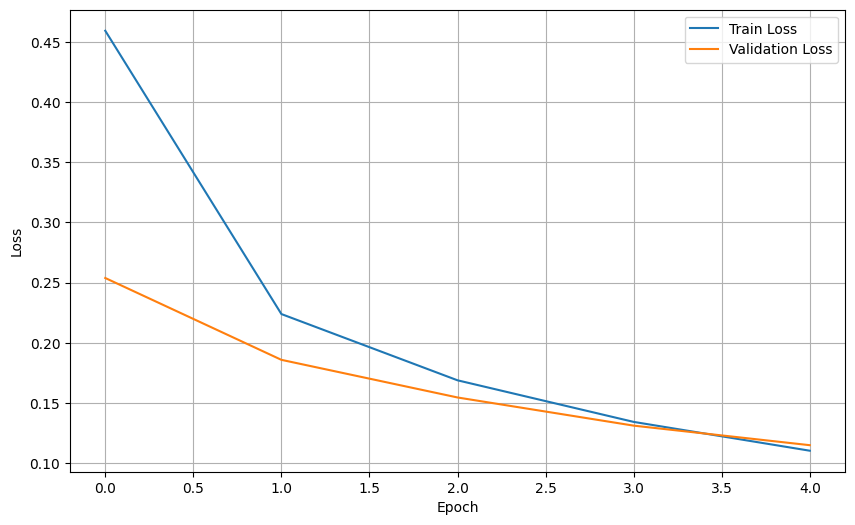


Learning Rate: 0.0005
EPOCH 1: Train Loss = 0.2544, Validation Loss = 0.1416
EPOCH 2: Train Loss = 0.1012, Validation Loss = 0.0939
EPOCH 3: Train Loss = 0.0646, Validation Loss = 0.0818
EPOCH 4: Train Loss = 0.0446, Validation Loss = 0.0780
EPOCH 5: Train Loss = 0.0313, Validation Loss = 0.0769
ACCURACY: 0.975700


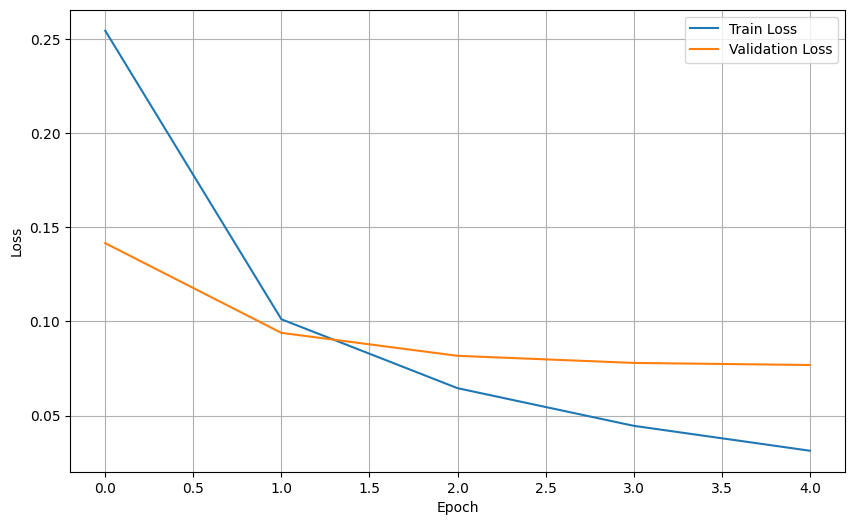


Learning Rate: 0.001
EPOCH 1: Train Loss = 0.2080, Validation Loss = 0.1174
EPOCH 2: Train Loss = 0.0832, Validation Loss = 0.0789
EPOCH 3: Train Loss = 0.0540, Validation Loss = 0.0856
EPOCH 4: Train Loss = 0.0405, Validation Loss = 0.0886
EPOCH 5: Train Loss = 0.0302, Validation Loss = 0.0740
ACCURACY: 0.979100


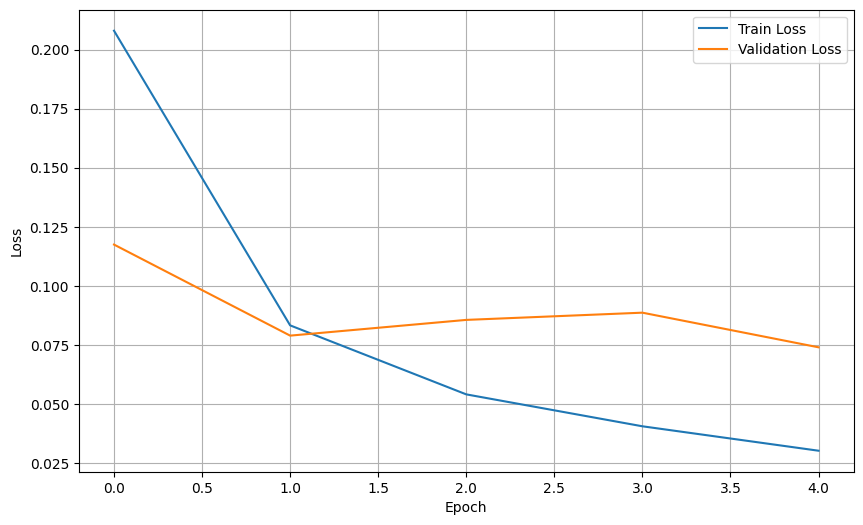


Learning Rate: 0.005
EPOCH 1: Train Loss = 0.2234, Validation Loss = 0.1445
EPOCH 2: Train Loss = 0.1345, Validation Loss = 0.1606
EPOCH 3: Train Loss = 0.1146, Validation Loss = 0.1304
EPOCH 4: Train Loss = 0.0997, Validation Loss = 0.1470
EPOCH 5: Train Loss = 0.0928, Validation Loss = 0.1474
ACCURACY: 0.972800


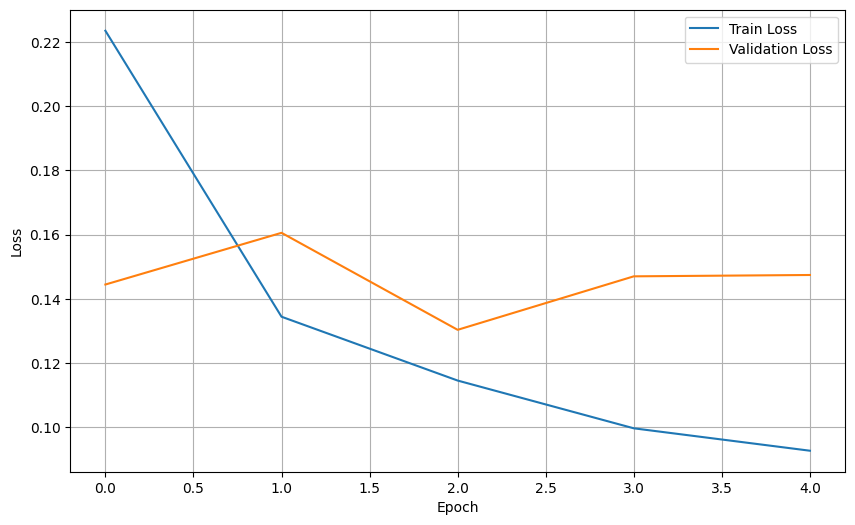


Learning Rate: 0.01
EPOCH 1: Train Loss = 0.2963, Validation Loss = 0.2016
EPOCH 2: Train Loss = 0.2047, Validation Loss = 0.2063
EPOCH 3: Train Loss = 0.1892, Validation Loss = 0.2052
EPOCH 4: Train Loss = 0.1828, Validation Loss = 0.2493
EPOCH 5: Train Loss = 0.1693, Validation Loss = 0.2259
ACCURACY: 0.945900


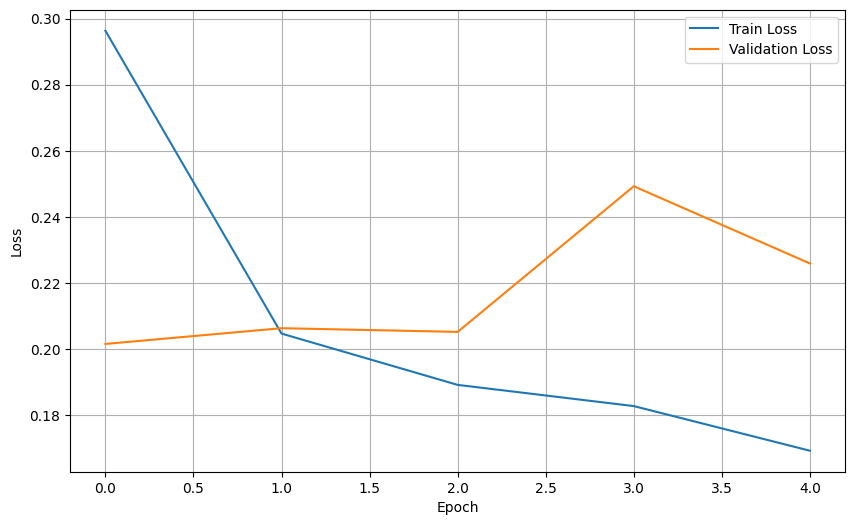


Learning Rate: 0.05
EPOCH 1: Train Loss = 0.8343, Validation Loss = 0.8840
EPOCH 2: Train Loss = 0.8122, Validation Loss = 0.6828
EPOCH 3: Train Loss = 0.7576, Validation Loss = 0.7162
EPOCH 4: Train Loss = 0.7554, Validation Loss = 0.7793
EPOCH 5: Train Loss = 0.7556, Validation Loss = 1.0103
ACCURACY: 0.691100


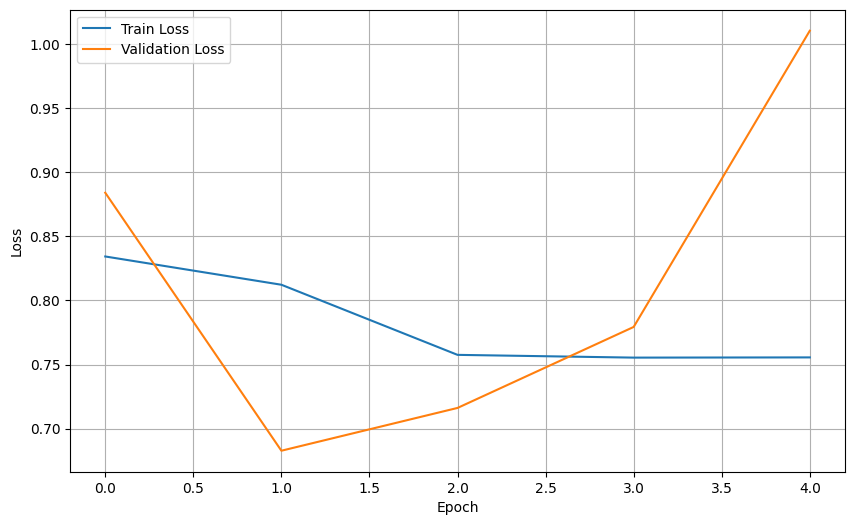


Learning Rate: 0.1
EPOCH 1: Train Loss = 1.9303, Validation Loss = 1.9194
EPOCH 2: Train Loss = 1.9982, Validation Loss = 1.9393
EPOCH 3: Train Loss = 1.9948, Validation Loss = 1.9570
EPOCH 4: Train Loss = 2.0159, Validation Loss = 1.9645
EPOCH 5: Train Loss = 1.9076, Validation Loss = 2.0165
ACCURACY: 0.222600


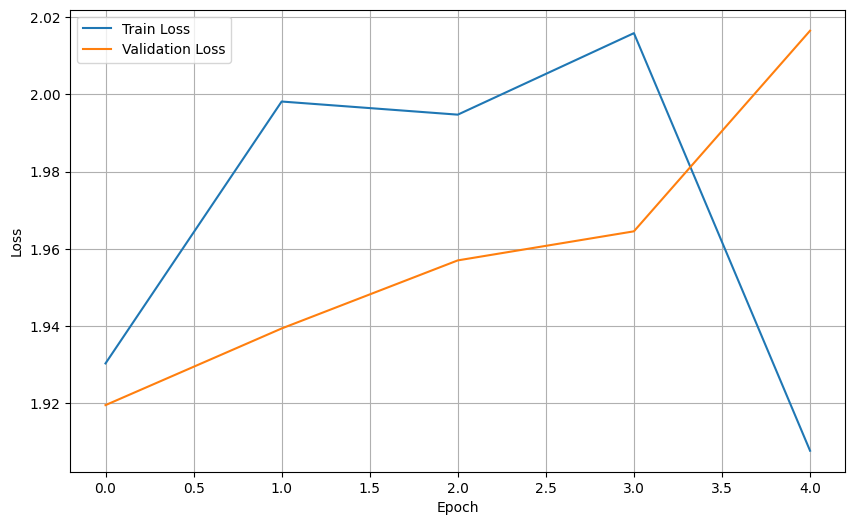


Learning Rate: 0.5
EPOCH 1: Train Loss = 5.0698, Validation Loss = 2.3932
EPOCH 2: Train Loss = 2.5035, Validation Loss = 2.3676
EPOCH 3: Train Loss = 2.3869, Validation Loss = 2.4134
EPOCH 4: Train Loss = 2.3871, Validation Loss = 2.4131
EPOCH 5: Train Loss = 2.3824, Validation Loss = 2.3893
ACCURACY: 0.103200


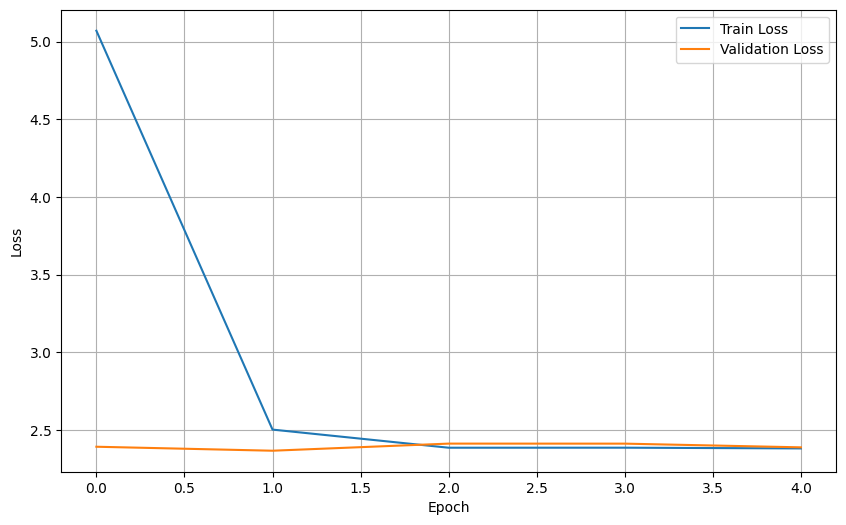

In [39]:
Learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
for lr in Learning_rates:
    print(f'Learning Rate: {lr}')
    model_Adam_LR = Model_Adam_LR(lr)
    training_loss_model_Adam_LR, val_loss_model_Adam_LR = train_the_model(model_Adam_LR)
    acc_model_Adam_LR = evaluate_model(model_Adam_LR)

    LR_model_names.append('Adam_LR=' + str(lr))
    LR_model_accuracies.append(acc_model_Adam_LR)
    plot_loss_curve(training_loss_model_Adam_LR, val_loss_model_Adam_LR)
    print()

## Accuracies

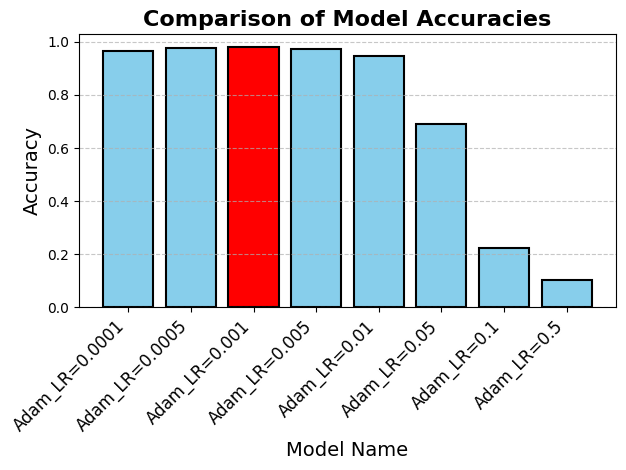

In [40]:
create_bar_chart(LR_model_names, LR_model_accuracies)

## Result

**Increasing Learning Rate:** Faster Convergence, Risk of Overshooting.  
**Decreasing Learning Rate:** Stable Convergence, Slow Convergence.  

As the learning rate increases, the accuracy decreases and the validation data loss increases, if we consider its value too low, the model training time increases.  
According to the above chart, the best learning rate value is 0.001, it has good learning time and high accuracy.

# Stop conditions

1. **Fixed Number of Epochs:** Training is stopped after a predefined number of epochs. This is the simplest and most commonly used method.

2. **Early Stopping:** Training is stopped when the model's performance on a validation set stops improving for a specified number of epochs. This helps to prevent overfitting.

3. **Threshold on Loss or Accuracy:** Training is stopped when the loss falls below or accuracy exceeds a certain threshold.

4. **Convergence:** Training is stopped when the change in loss or accuracy between consecutive epochs falls below a certain threshold.

5. **Time-based:** Training is stopped after a specified amount of time has elapsed.

In this code, only the condition of the number of epochs is examined.

# Hyperparameter Tuning

In [41]:
class Model_HT(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X),axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

## Batch size

In [42]:
batch_model_names = []
batch_model_accuracies = []

BATCH_SIZEs = [8, 16, 32, 64, 128]
EPOCHS = 5

Batch Size: 8
EPOCH 1: Train Loss = 0.1975, Validation Loss = 0.1068
EPOCH 2: Train Loss = 0.0854, Validation Loss = 0.1002
EPOCH 3: Train Loss = 0.0587, Validation Loss = 0.0955
EPOCH 4: Train Loss = 0.0427, Validation Loss = 0.0984
EPOCH 5: Train Loss = 0.0337, Validation Loss = 0.0993
ACCURACY: 0.978700


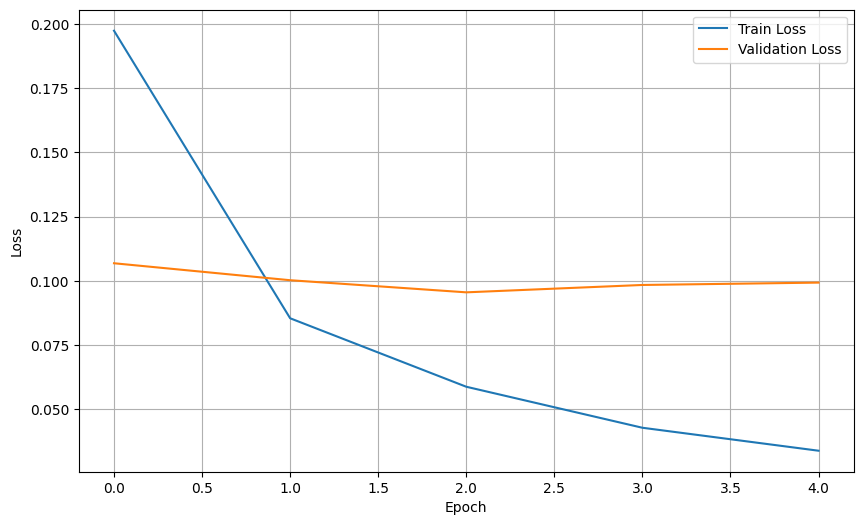


Batch Size: 16
EPOCH 1: Train Loss = 0.2110, Validation Loss = 0.1094
EPOCH 2: Train Loss = 0.0844, Validation Loss = 0.0934
EPOCH 3: Train Loss = 0.0561, Validation Loss = 0.0889
EPOCH 4: Train Loss = 0.0407, Validation Loss = 0.0995
EPOCH 5: Train Loss = 0.0287, Validation Loss = 0.0899
ACCURACY: 0.974800


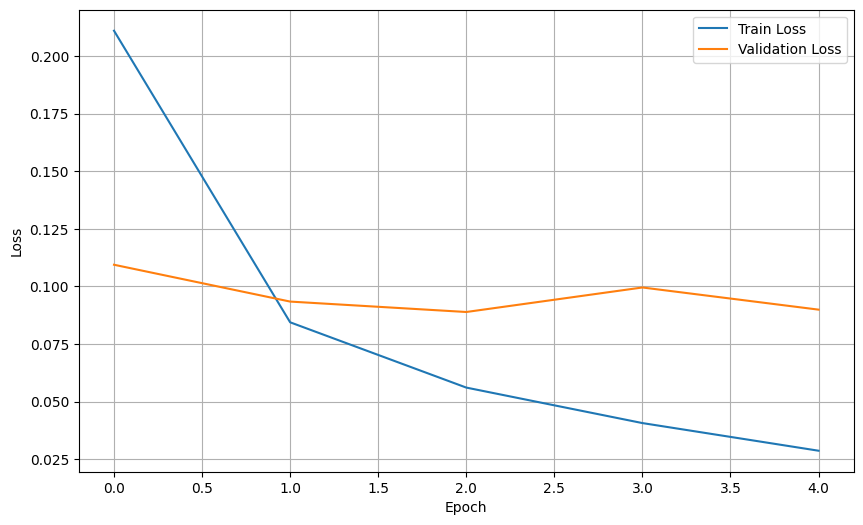


Batch Size: 32
EPOCH 1: Train Loss = 0.2336, Validation Loss = 0.1176
EPOCH 2: Train Loss = 0.0892, Validation Loss = 0.0960
EPOCH 3: Train Loss = 0.0586, Validation Loss = 0.0840
EPOCH 4: Train Loss = 0.0400, Validation Loss = 0.0774
EPOCH 5: Train Loss = 0.0296, Validation Loss = 0.0725
ACCURACY: 0.976637


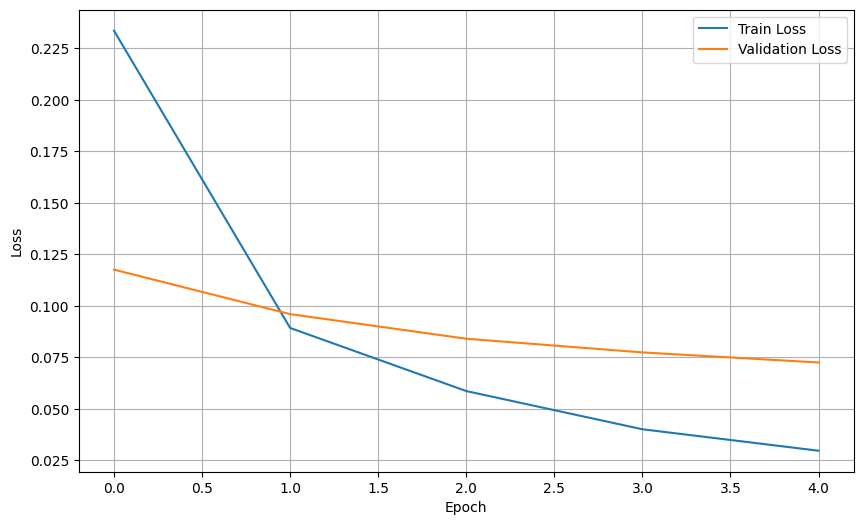


Batch Size: 64
EPOCH 1: Train Loss = 0.2740, Validation Loss = 0.1364
EPOCH 2: Train Loss = 0.1082, Validation Loss = 0.1034
EPOCH 3: Train Loss = 0.0697, Validation Loss = 0.0830
EPOCH 4: Train Loss = 0.0493, Validation Loss = 0.0834
EPOCH 5: Train Loss = 0.0350, Validation Loss = 0.0841
ACCURACY: 0.971537


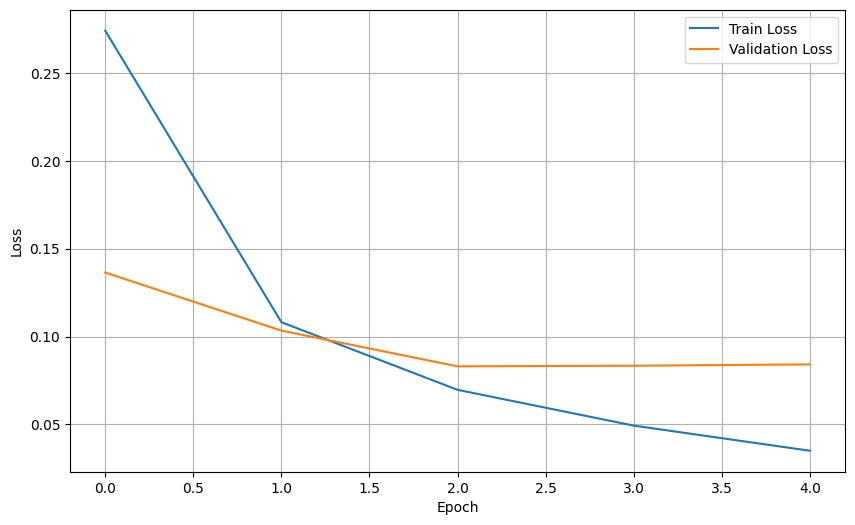


Batch Size: 128
EPOCH 1: Train Loss = 0.3332, Validation Loss = 0.1696
EPOCH 2: Train Loss = 0.1375, Validation Loss = 0.1221
EPOCH 3: Train Loss = 0.0898, Validation Loss = 0.0891
EPOCH 4: Train Loss = 0.0659, Validation Loss = 0.0920
EPOCH 5: Train Loss = 0.0479, Validation Loss = 0.0793
ACCURACY: 0.966673


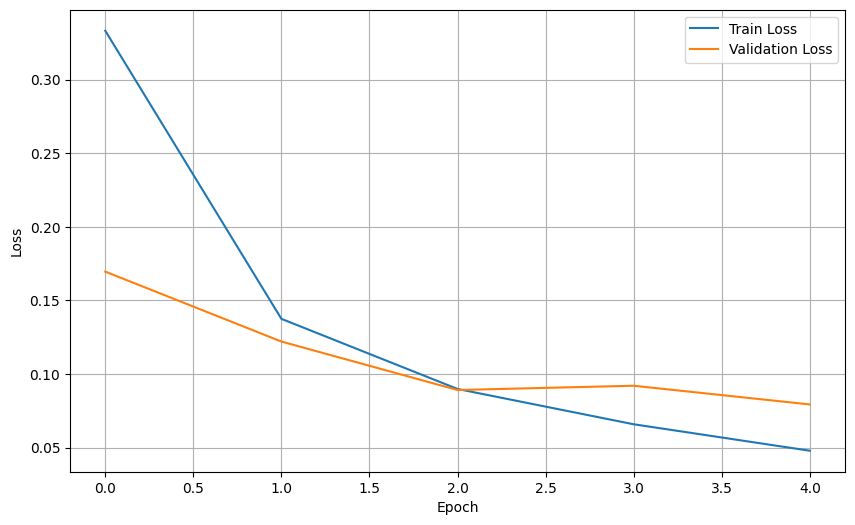

In [43]:
for batchsize in BATCH_SIZEs:
    model_batch = Model_HT()
    BATCH_SIZE = batchsize
    dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

    print(f'Batch Size: {batchsize}')
    training_loss_model_batch, val_loss_model_batch = train_the_model(model_batch)
    acc_model_batch = evaluate_model(model_batch)

    batch_model_names.append('Batch=' + str(batchsize))
    batch_model_accuracies.append(acc_model_batch)
    plot_loss_curve(training_loss_model_batch, val_loss_model_batch)
    print()

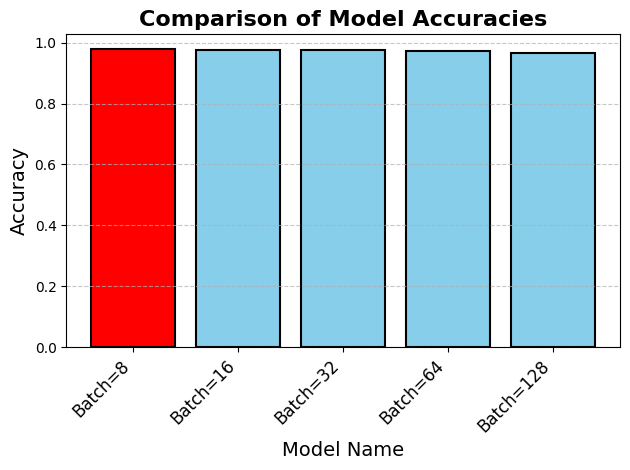

In [44]:
create_bar_chart(batch_model_names, batch_model_accuracies)

### Result  

**Increasing Batch Size:** Smoother Gradient Estimates, Better Utilization of Hardware, Higher Memory Requirement.  
**Decreasing Batch Size:** More Frequent Updates, Noisier Gradient Estimates, Lower Memory Requirement.  

As the batch increases, the amount of loss increases, and the best value for it is 16 and 32.

## Epoch

In [45]:
BATCH_SIZE = 16
EPOCHS_list = [2, 4, 5, 6, 8, 10]

epoch_model_names = []
epoch_model_accuracies = []

Epoch: 2
EPOCH 1: Train Loss = 0.2083, Validation Loss = 0.1006
EPOCH 2: Train Loss = 0.0824, Validation Loss = 0.0811
ACCURACY: 0.975100


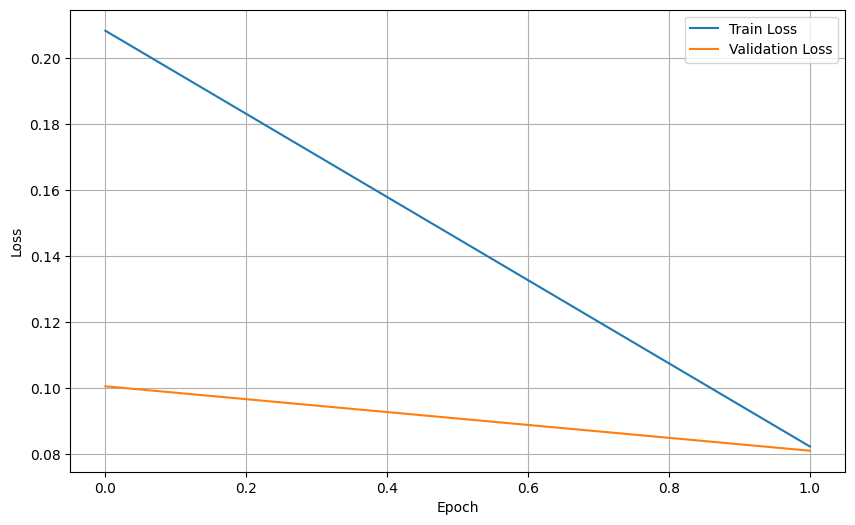


Epoch: 4
EPOCH 1: Train Loss = 0.2062, Validation Loss = 0.1085
EPOCH 2: Train Loss = 0.0832, Validation Loss = 0.0885
EPOCH 3: Train Loss = 0.0558, Validation Loss = 0.0845
EPOCH 4: Train Loss = 0.0401, Validation Loss = 0.0788
ACCURACY: 0.975400


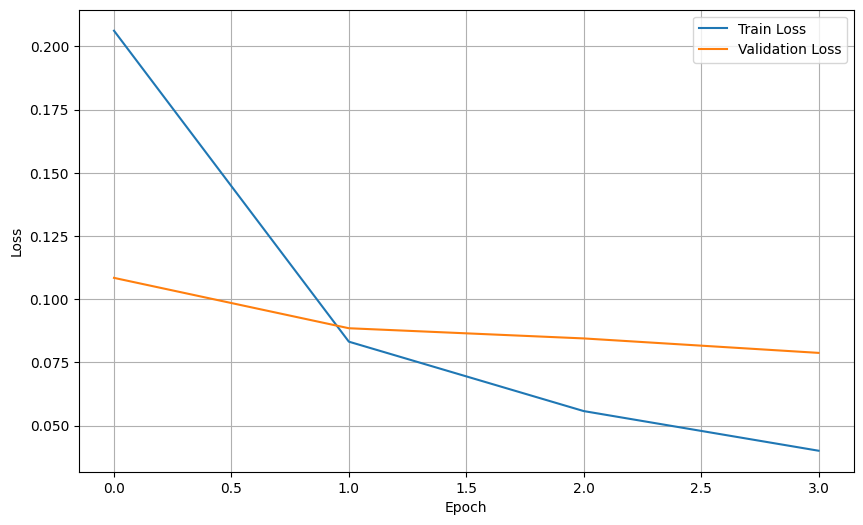


Epoch: 5
EPOCH 1: Train Loss = 0.2095, Validation Loss = 0.1095
EPOCH 2: Train Loss = 0.0846, Validation Loss = 0.0829
EPOCH 3: Train Loss = 0.0541, Validation Loss = 0.0793
EPOCH 4: Train Loss = 0.0399, Validation Loss = 0.0967
EPOCH 5: Train Loss = 0.0298, Validation Loss = 0.0713
ACCURACY: 0.980200


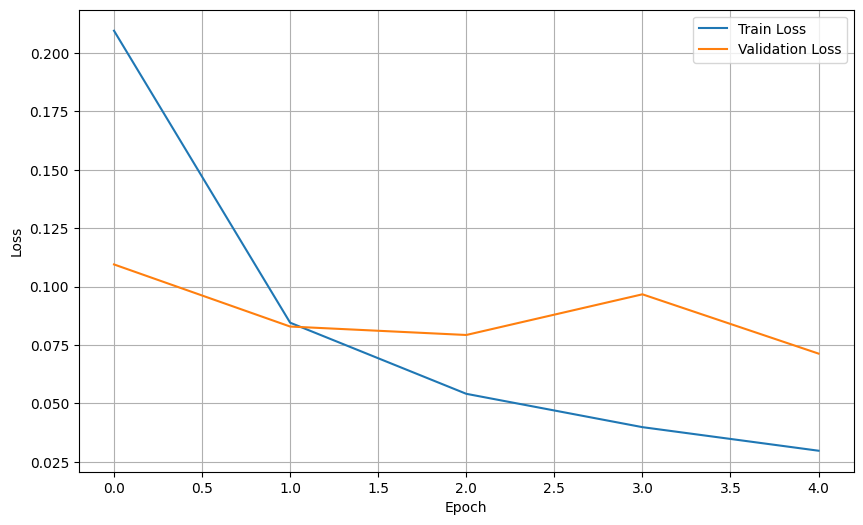


Epoch: 6
EPOCH 1: Train Loss = 0.2091, Validation Loss = 0.1050
EPOCH 2: Train Loss = 0.0846, Validation Loss = 0.0977
EPOCH 3: Train Loss = 0.0553, Validation Loss = 0.0797
EPOCH 4: Train Loss = 0.0379, Validation Loss = 0.0954
EPOCH 5: Train Loss = 0.0287, Validation Loss = 0.0877
EPOCH 6: Train Loss = 0.0236, Validation Loss = 0.0851
ACCURACY: 0.976600


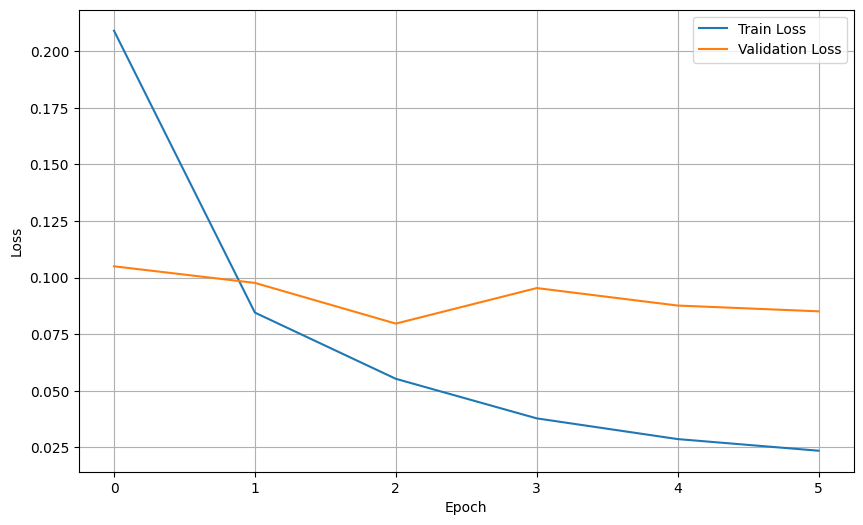


Epoch: 8
EPOCH 1: Train Loss = 0.2085, Validation Loss = 0.1084
EPOCH 2: Train Loss = 0.0853, Validation Loss = 0.0933
EPOCH 3: Train Loss = 0.0553, Validation Loss = 0.0813
EPOCH 4: Train Loss = 0.0401, Validation Loss = 0.0902
EPOCH 5: Train Loss = 0.0301, Validation Loss = 0.0887
EPOCH 6: Train Loss = 0.0230, Validation Loss = 0.0797
EPOCH 7: Train Loss = 0.0211, Validation Loss = 0.0953
EPOCH 8: Train Loss = 0.0160, Validation Loss = 0.1022
ACCURACY: 0.980900


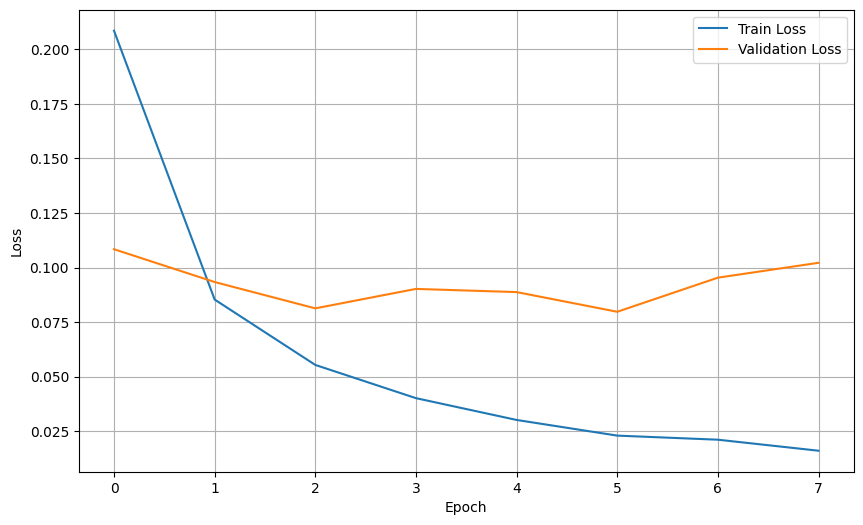


Epoch: 10
EPOCH 1: Train Loss = 0.2097, Validation Loss = 0.1047
EPOCH 2: Train Loss = 0.0834, Validation Loss = 0.0810
EPOCH 3: Train Loss = 0.0552, Validation Loss = 0.0903
EPOCH 4: Train Loss = 0.0403, Validation Loss = 0.0747
EPOCH 5: Train Loss = 0.0306, Validation Loss = 0.0910
EPOCH 6: Train Loss = 0.0249, Validation Loss = 0.0886
EPOCH 7: Train Loss = 0.0200, Validation Loss = 0.0887
EPOCH 8: Train Loss = 0.0163, Validation Loss = 0.0853
EPOCH 9: Train Loss = 0.0146, Validation Loss = 0.1047
EPOCH 10: Train Loss = 0.0145, Validation Loss = 0.0997
ACCURACY: 0.978800


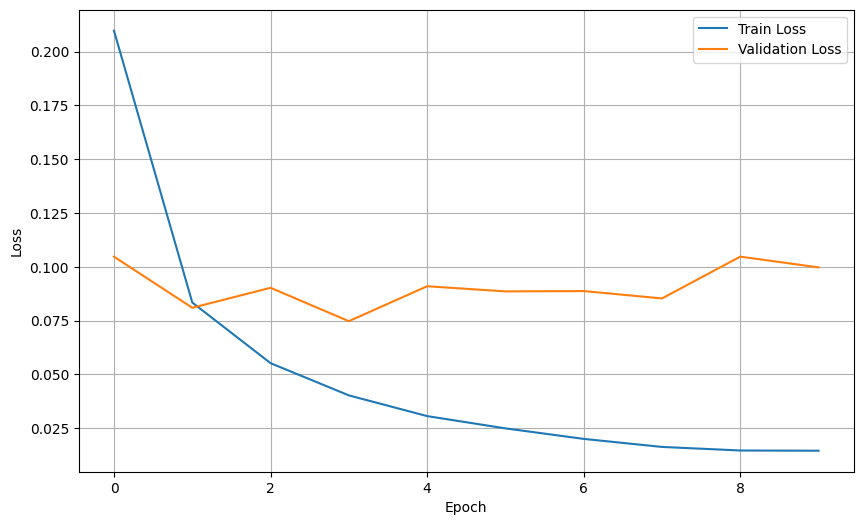

In [46]:
model_epoch = Model_HT()
for epo in EPOCHS_list:
    model_epoch = Model_HT()
    EPOCHS = epo
    dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

    print(f'Epoch: {epo}')
    training_loss_model_epoch, val_loss_model_epoch = train_the_model(model_epoch)
    acc_model_epoch = evaluate_model(model_epoch)

    epoch_model_names.append('Epoch=' + str(epo))
    epoch_model_accuracies.append(acc_model_epoch)
    plot_loss_curve(training_loss_model_epoch, val_loss_model_epoch)
    print()

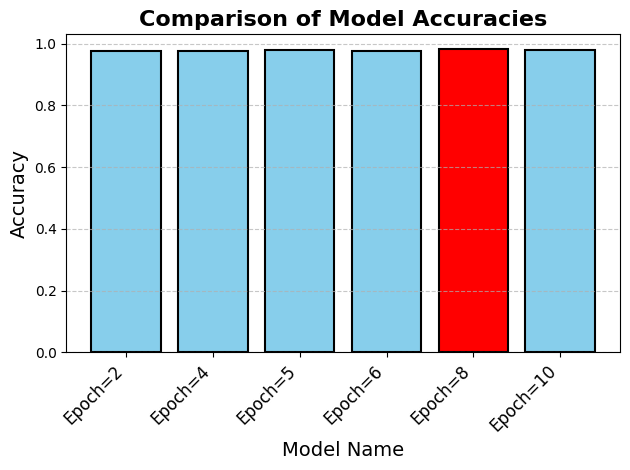

In [47]:
create_bar_chart(epoch_model_names, epoch_model_accuracies)

### Result  

**Increasing the Number of Epochs:** Better Model Fit, Better Model Fit, Longer Training Time.  
**Decreasing the Number of Epochs:** Faster Training, Risk of Underfitting, Lower Accuracy.  

According to the loss validation date diagram, the validation loss will increase in the 6th epoch and the model will be overfit.  
If we set the number of epochs to 1, the model will suffer from underfit.  

So best number of epochs is 5.  

# Activation function

## Default value

In [48]:
act_model_names = []
act_model_accuracies = []

In [49]:
BATCH_SIZE = 16
EPOCHS = 5
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

## Sigmoid

The sigmoid activation function maps input values to a range between 0 and 1,  making it suitable for binary classification problems where outputs are interpreted as probabilities. However, it can suffer from the vanishing gradient problem, which can slow down or prevent the training of deep networks.  
**Benefits of Sigmoid Activation Function:** Probability Output, Smooth Gradient.

In [50]:
class Model_Sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.Sigmoid(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 0.3215, Validation Loss = 0.1703
EPOCH 2: Train Loss = 0.1391, Validation Loss = 0.1140
EPOCH 3: Train Loss = 0.0872, Validation Loss = 0.0936
EPOCH 4: Train Loss = 0.0594, Validation Loss = 0.0838
EPOCH 5: Train Loss = 0.0430, Validation Loss = 0.0693
ACCURACY: 0.979900


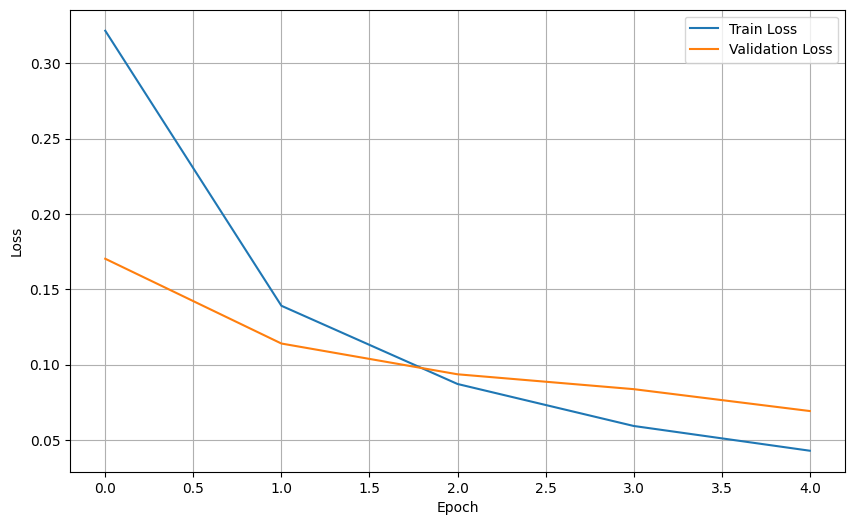

In [51]:
model_sigmoid = Model_Sigmoid()
training_loss_model_sigmoid, val_loss_model_sigmoid = train_the_model(model_sigmoid)
acc_model_sigmoid = evaluate_model(model_sigmoid)

act_model_names.append('model_sigmoid')
act_model_accuracies.append(acc_model_sigmoid)
plot_loss_curve(training_loss_model_sigmoid, val_loss_model_sigmoid)

## ReLU

The ReLU (Rectified Linear Unit) activation function is defined as 
ReLU(x)=max(0,x), which effectively sets all negative input values to zero while keeping positive values unchanged.  
**Benefits of ReLU Activation Function:** Simplicity, Mitigates Vanishing Gradient Problem, Sparse Activation, Improves Gradient Propagation.  

In [52]:
class Model_ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())
        self.to(get_default_device())
        
    def forward(self,X):
        return self.layers(X)

    def predict(self,X):
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=-1)
            
    def fit(self,X,Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred,Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 0.2077, Validation Loss = 0.1050
EPOCH 2: Train Loss = 0.0844, Validation Loss = 0.0850
EPOCH 3: Train Loss = 0.0547, Validation Loss = 0.0813
EPOCH 4: Train Loss = 0.0396, Validation Loss = 0.0717
EPOCH 5: Train Loss = 0.0292, Validation Loss = 0.0774
ACCURACY: 0.978100


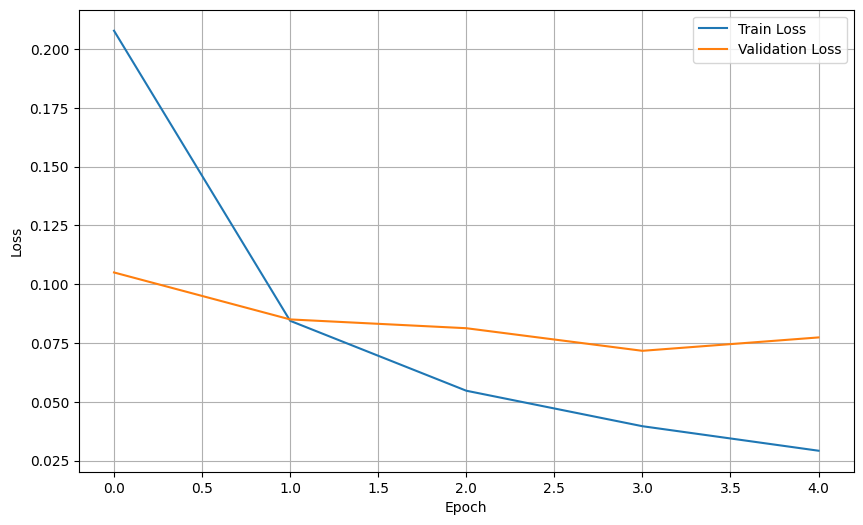

In [53]:
model_ReLU = Model_ReLU()
training_loss_model_ReLU, val_loss_model_ReLU = train_the_model(model_ReLU)
acc_model_ReLU = evaluate_model(model_ReLU)

act_model_names.append('model_ReLU')
act_model_accuracies.append(acc_model_ReLU)
plot_loss_curve(training_loss_model_ReLU, val_loss_model_ReLU)

## Accuracies

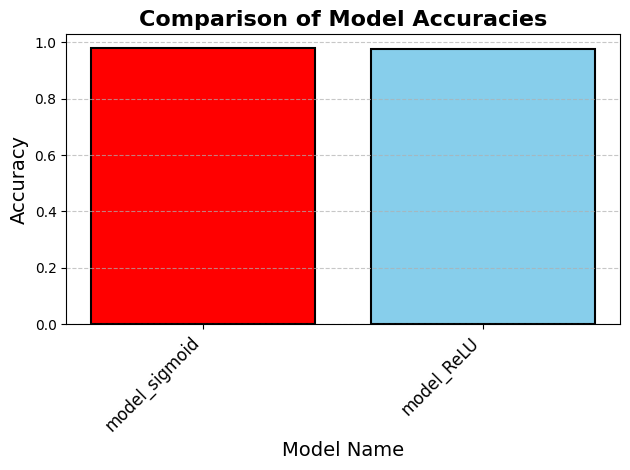

In [54]:
create_bar_chart(act_model_names, act_model_accuracies)

## Result

ReLU is computationally more efficient than sigmoid as it involves simple thresholding at zero, which makes it faster to compute.  
Networks with ReLU activation typically converge faster during training compared to those using sigmoid activation.  

According to the graphs above, ReLU has less loss and is more accurate.  

# Drop out

Dropout is a regularization technique used to prevent overfitting in neural networks. It works by randomly "dropping out" (i.e., setting to zero) a fraction of the neurons during training, which forces the network to learn more robust features and prevents it from relying too heavily on any individual neuron.

## Defalut value

In [55]:
dropout_model_names = []
dropout_model_accuracies = []

In [56]:
BATCH_SIZE = 16
EPOCHS = 5
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

## Model with drop out

In [57]:
class Model_Dropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())
        self.to(get_default_device())
        
    def forward(self, X):
        return self.layers(X)

    def predict(self, X):
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=-1)
            
    def fit(self, X, Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred, Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

Drop out: 0
EPOCH 1: Train Loss = 0.2102, Validation Loss = 0.1120
EPOCH 2: Train Loss = 0.0838, Validation Loss = 0.1096
EPOCH 3: Train Loss = 0.0528, Validation Loss = 0.0811
EPOCH 4: Train Loss = 0.0390, Validation Loss = 0.0720
EPOCH 5: Train Loss = 0.0292, Validation Loss = 0.0937
ACCURACY: 0.973700


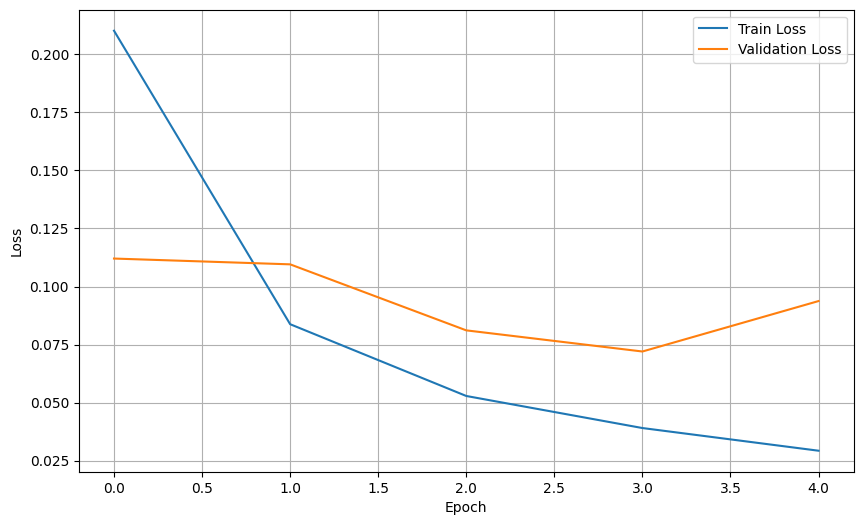

Drop out: 0.1
EPOCH 1: Train Loss = 0.2183, Validation Loss = 0.1149
EPOCH 2: Train Loss = 0.0923, Validation Loss = 0.0955
EPOCH 3: Train Loss = 0.0638, Validation Loss = 0.0763
EPOCH 4: Train Loss = 0.0484, Validation Loss = 0.0822
EPOCH 5: Train Loss = 0.0389, Validation Loss = 0.0857
ACCURACY: 0.975300


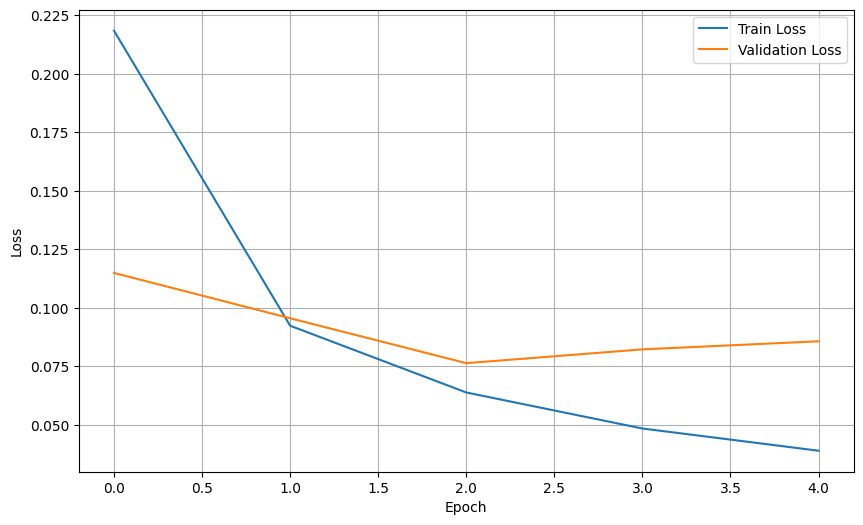

Drop out: 0.2
EPOCH 1: Train Loss = 0.2302, Validation Loss = 0.1194
EPOCH 2: Train Loss = 0.1029, Validation Loss = 0.0972
EPOCH 3: Train Loss = 0.0756, Validation Loss = 0.0869
EPOCH 4: Train Loss = 0.0592, Validation Loss = 0.0889
EPOCH 5: Train Loss = 0.0494, Validation Loss = 0.0775
ACCURACY: 0.979200


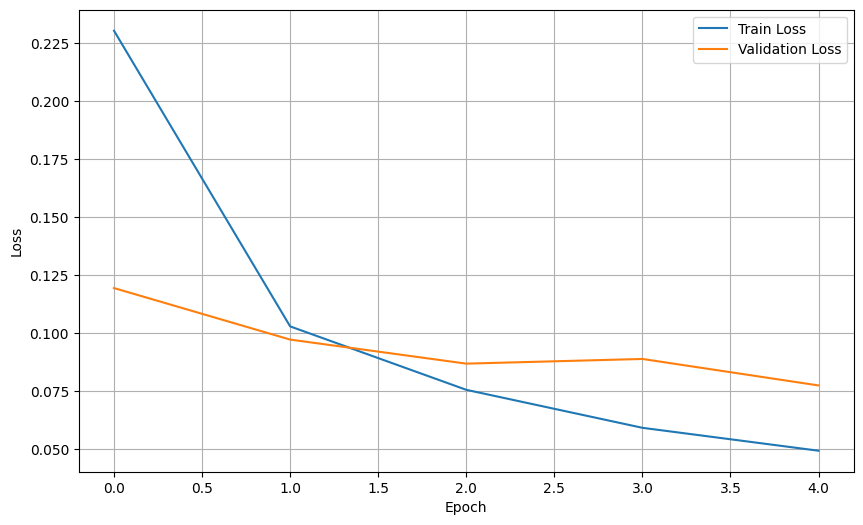

Drop out: 0.4
EPOCH 1: Train Loss = 0.2576, Validation Loss = 0.1177
EPOCH 2: Train Loss = 0.1281, Validation Loss = 0.0930
EPOCH 3: Train Loss = 0.1023, Validation Loss = 0.0882
EPOCH 4: Train Loss = 0.0818, Validation Loss = 0.0825
EPOCH 5: Train Loss = 0.0763, Validation Loss = 0.0715
ACCURACY: 0.980900


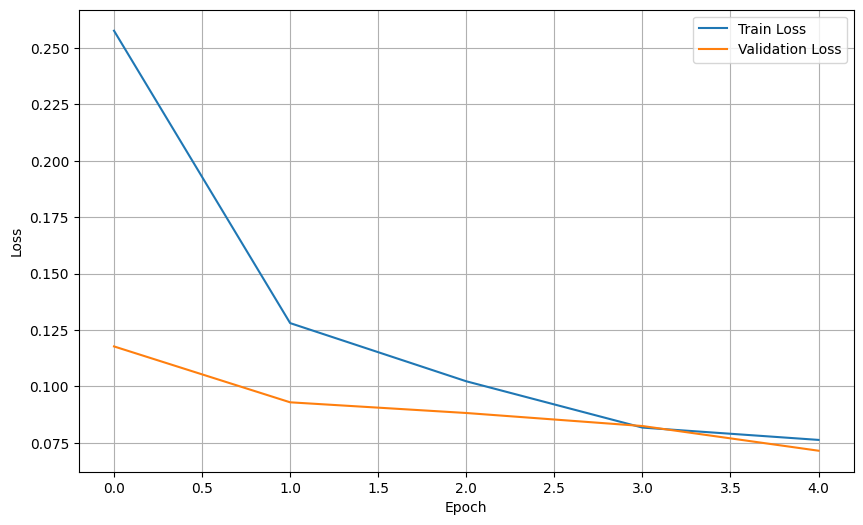

Drop out: 0.6
EPOCH 1: Train Loss = 0.3140, Validation Loss = 0.1284
EPOCH 2: Train Loss = 0.1771, Validation Loss = 0.1079
EPOCH 3: Train Loss = 0.1461, Validation Loss = 0.0935
EPOCH 4: Train Loss = 0.1279, Validation Loss = 0.0821
EPOCH 5: Train Loss = 0.1191, Validation Loss = 0.0791
ACCURACY: 0.978200


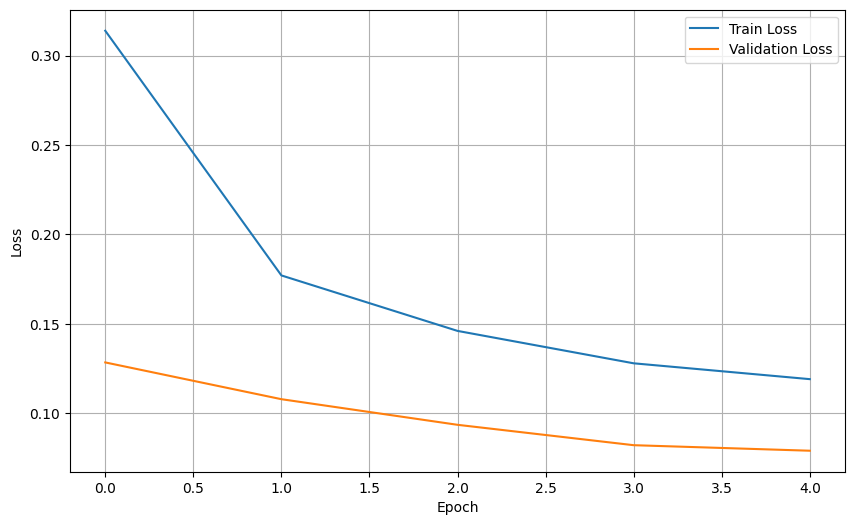

Drop out: 0.8
EPOCH 1: Train Loss = 0.4489, Validation Loss = 0.1731
EPOCH 2: Train Loss = 0.3013, Validation Loss = 0.1311
EPOCH 3: Train Loss = 0.2669, Validation Loss = 0.1107
EPOCH 4: Train Loss = 0.2530, Validation Loss = 0.1065
EPOCH 5: Train Loss = 0.2351, Validation Loss = 0.0993
ACCURACY: 0.970900


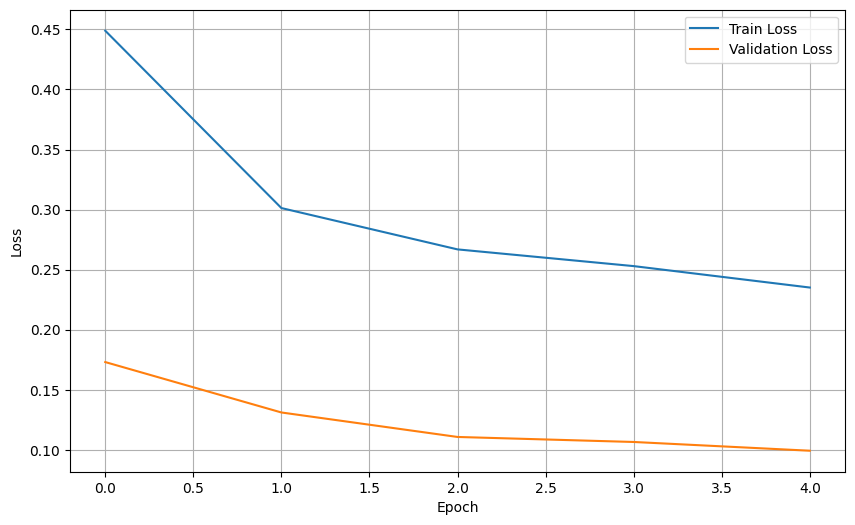

In [58]:
DROP_OUTs = [0, 0.1, 0.2, 0.4, 0.6, 0.8]

for dropout in DROP_OUTs:
    print(f'Drop out: {dropout}')
    model_dropout = Model_Dropout(dropout)
    training_loss_model_dropout, val_loss_model_dropout = train_the_model(model_dropout)
    acc_model_dropout = evaluate_model(model_dropout)
    
    dropout_model_names.append('Drop out=' + str(dropout))
    dropout_model_accuracies.append(acc_model_dropout)
    plot_loss_curve(training_loss_model_dropout, val_loss_model_dropout)

## Accuracies

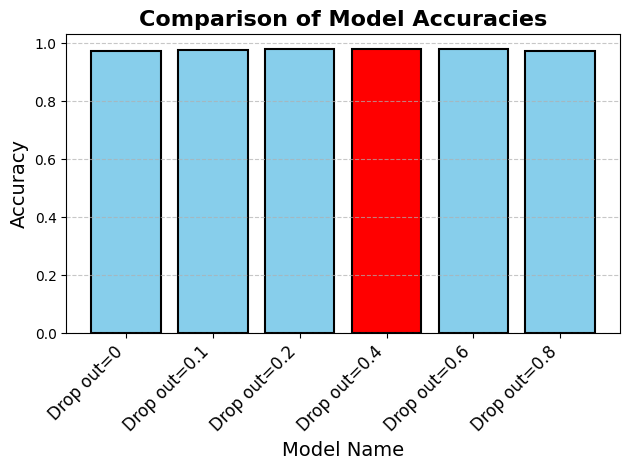

In [59]:
create_bar_chart(dropout_model_names, dropout_model_accuracies)

## Result

**dropout benefits:** Reduced Overfitting, Improved Generalization.  

As the dropout increases, the value of Loss increases and according to the results, the model without drop performs better. 

# Batch normalization

Batch normalization is a technique to improve the training of deep neural networks by standardizing the inputs to a layer for each mini-batch. This process helps to stabilize and accelerate the training process. Batch normalization works by normalizing the activations of each layer to have a mean of zero and a variance of one.

## Default value

In [60]:
batch_normal_model_names = []
batch_normal_model_accuracies = []

In [61]:
BATCH_SIZE = 16
EPOCHS = 5
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

## Model with batch normalization

In [62]:
class Model_BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())
        self.to(get_default_device())
        
    def forward(self, X):
        return self.layers(X)

    def predict(self, X):
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=-1)
            
    def fit(self, X, Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred, Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 0.2424, Validation Loss = 0.1077
EPOCH 2: Train Loss = 0.1289, Validation Loss = 0.0940
EPOCH 3: Train Loss = 0.1009, Validation Loss = 0.0819
EPOCH 4: Train Loss = 0.0830, Validation Loss = 0.0823
EPOCH 5: Train Loss = 0.0668, Validation Loss = 0.0741
ACCURACY: 0.977900


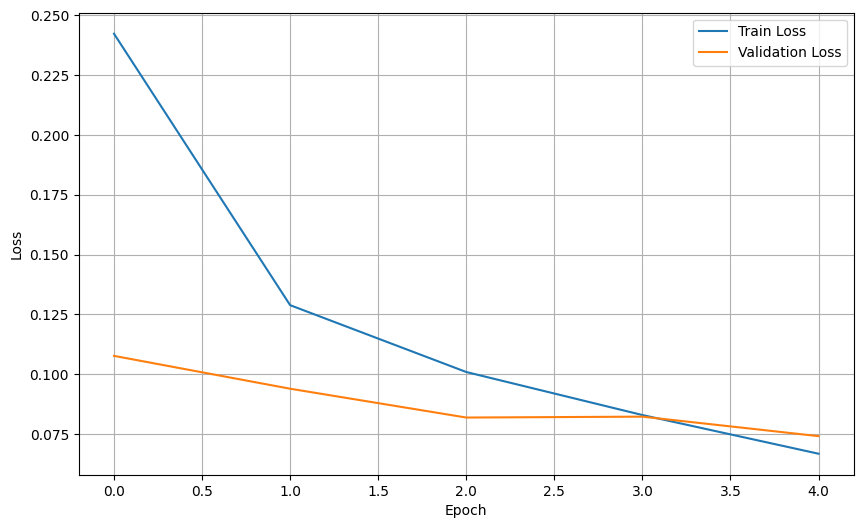

In [63]:
model_batch_normal = Model_BatchNorm()
training_loss_model_batch_normal, val_loss_model_batch_normal = train_the_model(model_batch_normal)
acc_model_batch_normal = evaluate_model(model_batch_normal)

batch_normal_model_names.append('model_with_batch_normal')
batch_normal_model_accuracies.append(acc_model_batch_normal)
plot_loss_curve(training_loss_model_batch_normal, val_loss_model_batch_normal)

In [64]:
class Model_No_BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())
        self.to(get_default_device())
        
    def forward(self, X):
        return self.layers(X)

    def predict(self, X):
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=-1)
            
    def fit(self, X, Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred, Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 0.2089, Validation Loss = 0.1001
EPOCH 2: Train Loss = 0.0839, Validation Loss = 0.0906
EPOCH 3: Train Loss = 0.0554, Validation Loss = 0.0843
EPOCH 4: Train Loss = 0.0393, Validation Loss = 0.0839
EPOCH 5: Train Loss = 0.0301, Validation Loss = 0.0780
ACCURACY: 0.977800


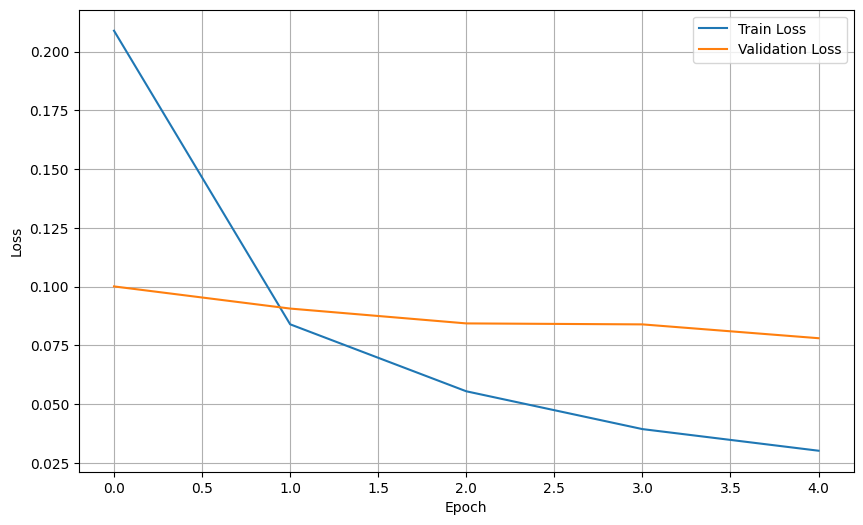

In [65]:
model_no_batch_normal = Model_No_BatchNorm()
training_loss_model_no_batch_normal, val_loss_model_no_batch_normal = train_the_model(model_no_batch_normal)
acc_model_no_batch_normal = evaluate_model(model_no_batch_normal)

batch_normal_model_names.append('model_without_batch_normal')
batch_normal_model_accuracies.append(acc_model_no_batch_normal)
plot_loss_curve(training_loss_model_no_batch_normal, val_loss_model_no_batch_normal)

## Accuracies

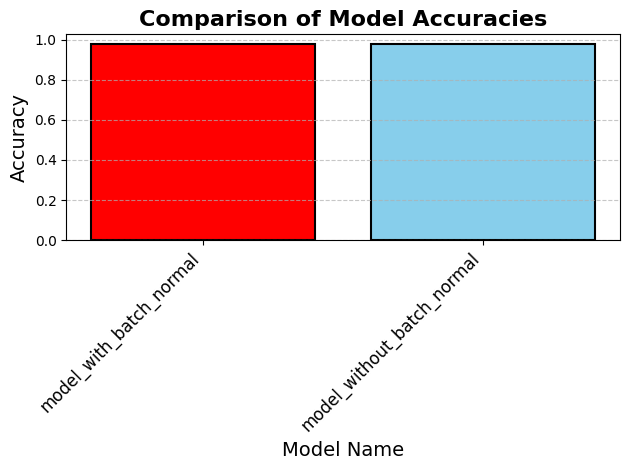

In [66]:
create_bar_chart(batch_normal_model_names, batch_normal_model_accuracies)

## Result

**Benefit batch normalization:** Stabilized Training, Faster Learning, Reduced Need for Careful Initialization.  

Model with out batch normalization has lower loss.  

# Best Model

## Default value

In [67]:
BATCH_SIZE = 16
EPOCHS = 5
dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)

## Model

In [68]:
class Model_Best(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())
        self.to(get_default_device())
        
    def forward(self, X):
        return self.layers(X)

    def predict(self, X):
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=-1)
            
    def fit(self, X, Y):
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss(y_pred, Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

EPOCH 1: Train Loss = 0.2111, Validation Loss = 0.0978
EPOCH 2: Train Loss = 0.0845, Validation Loss = 0.0867
EPOCH 3: Train Loss = 0.0537, Validation Loss = 0.0695
EPOCH 4: Train Loss = 0.0378, Validation Loss = 0.0818
EPOCH 5: Train Loss = 0.0304, Validation Loss = 0.0968
ACCURACY: 0.975000


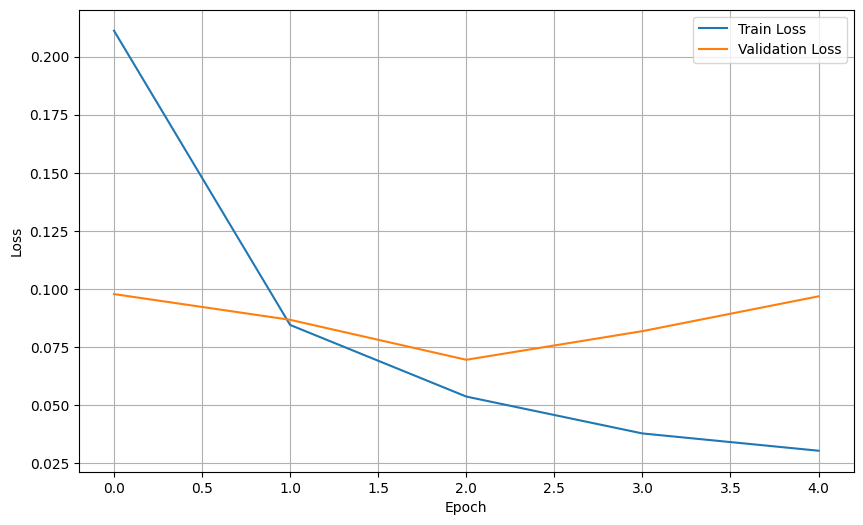

In [69]:
model_best = Model_Best()
training_loss_model_best, val_loss_model_best = train_the_model(model_best)
acc_model_best = evaluate_model(model_best)

plot_loss_curve(training_loss_model_best, val_loss_model_best)

# Resources

https://pytorch.org  
https://chatgpt.com